In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu

import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from missingpy import MissForest

from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from bayes_opt import BayesianOptimization

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_metric
import lightgbm as lightgbm

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.utils.class_weight import compute_class_weight

In [2]:
loan_result = pd.read_csv("loan_result.csv")
log_data = pd.read_csv("log_data.csv")
user_spec = pd.read_csv("user_spec.csv")

# EDA

## 1. 대출상품결과(loan_result)

In [3]:
loan_result.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN


loan_limit, loan_rate 결측인 행 삭제\
데이터분석리그 퓨처스부문 문제 및 데이터 자주 묻는 질문 (ver. 9/20) 7번

In [4]:
loan_result = loan_result[(-loan_result["loan_limit"].isna()) & (-loan_result["loan_rate"].isna())]

loan_limit 반올림 과정에서 0이 된 값이 있을 수 있기 때문에 전체적으로 25만을 더해줌.

In [5]:
loan_result["loan_limit"] += 250000

한도 로그 변환 변수 추가

In [6]:
loan_result["log_loan_limit"] = np.log(loan_result["loan_limit"])

## 2. 유저로그데이터(log_data)

In [7]:
log_data

,user_id,event,timestamp,mp_os,mp_app_version,date_cd
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8.4,2022-03-25
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25
...,...,...,...,...,...,...
17843988,242442,StartLoanApply,2022-05-27 16:08:21,Android,3.13.0,2022-05-27
17843989,242442,EndLoanApply,2022-05-27 16:08:21,Android,3.13.0,2022-05-27
17843990,593062,OpenApp,2022-05-27 16:19:10,Android,3.13.0,2022-05-27
17843991,593062,Login,2022-05-27 16:19:15,Android,3.13.0,2022-05-27


In [8]:
log_data.isna().sum()

user_id                0
event                  0
timestamp              0
mp_os                980
mp_app_version    660597
date_cd                0
dtype: int64

## 3. 유저스펙테이블(user_spec)

In [9]:
user_spec

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,1249046,118218,1985.0,1.0,2022-06-07 06:28:18,660.0,108000000.0,PRIVATEBUSINESS,20151101.0,기타,자가,1000000.0,기타,0.0,NaN,4.0,162000000.0
1,954900,553686,1968.0,1.0,2022-06-07 14:29:03,870.0,30000000.0,PRIVATEBUSINESS,20070201.0,정규직,기타가족소유,30000000.0,대환대출,0.0,NaN,1.0,27000000.0
2,137274,59516,1997.0,1.0,2022-06-07 21:40:22,710.0,30000000.0,FREELANCER,20210901.0,기타,기타가족소유,10000000.0,생활비,0.0,NaN,5.0,15000000.0
3,1570936,167320,1989.0,1.0,2022-06-07 09:40:27,820.0,62000000.0,EARNEDINCOME,20170101.0,정규직,자가,2000000.0,생활비,0.0,NaN,7.0,344000000.0
4,967833,33400,2000.0,1.0,2022-06-07 08:55:07,630.0,36000000.0,EARNEDINCOME,20210901.0,정규직,기타가족소유,5000000.0,생활비,0.0,0.0,1.0,16000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394211,1864587,489900,2000.0,1.0,2022-03-22 14:55:32,590.0,25000000.0,FREELANCER,202106.0,기타,기타가족소유,5000000.0,사업자금,NaN,NaN,NaN,NaN
1394212,1327066,151422,1955.0,1.0,2022-03-22 01:19:24,980.0,20000000.0,OTHERINCOME,NaN,기타,자가,50000000.0,생활비,NaN,NaN,1.0,NaN
1394213,1319606,173524,1983.0,1.0,2022-03-22 07:34:32,750.0,75000000.0,EARNEDINCOME,200908.0,정규직,자가,100000000.0,대환대출,NaN,NaN,8.0,200000000.0
1394214,1482466,766546,1975.0,1.0,2022-03-22 22:12:35,640.0,50000000.0,EARNEDINCOME,201705.0,정규직,자가,10000000.0,대환대출,NaN,NaN,10.0,117000000.0


데이터 전체 행 수 : 1,394,216

In [10]:
len(user_spec)

1394216

application_id(신청서) 수 : 1,394,216 ( == 데이터 전체 행 수)

In [11]:
len(user_spec["application_id"].unique())

1394216

user_id(이용자) 수 : 405,213\
 => 평균적으로 이용자 한 명당 약 3번 정도 핀다 신청을 함

In [12]:
len(user_spec["user_id"].unique())

405213

### loan_result에는 있지만 user_spec에는 없는 경우 and user_spec에는 있지만 loan_result에는 없는 경우

In [13]:
loan_app_id = loan_result['application_id'].unique()
user_app_id = user_spec['application_id'].unique()

In [14]:
print("loan_result에는 있지만 user_spec에는 없는 경우 :", sum(1-np.isin(loan_app_id, user_app_id)))
print("user_spec에는 있지만 loan_result에는 없는 경우 :", sum(1-np.isin(user_app_id, loan_app_id)))

loan_result에는 있지만 user_spec에는 없는 경우 : 0
user_spec에는 있지만 loan_result에는 없는 경우 : 425489


### 날짜 형식 맞춰주기

년월까지만 있는 형식도 있고 년월일까지 있는 형식도 있어서 전체적으로 년월 형식으로 바꿔줌.

In [15]:
# company_enter_month
company_enter_month_d = []
for i in tqdm_notebook(user_spec["company_enter_month"].astype(str)):
    try:
        company_enter_month_d.append(pd.to_datetime(i[0:6]+"01"))
    except:
        company_enter_month_d.append(np.nan)

  0%|          | 0/1394216 [00:00<?, ?it/s]

In [16]:
user_spec["company_enter_month"] = company_enter_month_d

In [17]:
# insert_time
user_spec["insert_time"] = pd.to_datetime(user_spec["insert_time"])

### 신용점수

{'whiskers': [<matplotlib.lines.Line2D at 0x1b3b8f9c5b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b3b8f9cc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b3b8f9c250>],
 'medians': [<matplotlib.lines.Line2D at 0x1b3b8f8c370>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b3b8f8c6d0>],
 'means': []}

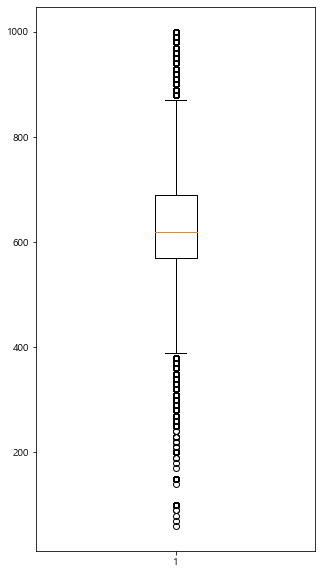

In [18]:
plt.figure(figsize=(5,10))
plt.boxplot(user_spec.loc[user_spec["credit_score"].notna(),"credit_score"])

결측인 행이 꽤 많음

In [19]:
user_spec["credit_score"].isna().sum()

105115

### purpose 명칭 통합

In [20]:
user_spec["purpose"].value_counts()

생활비             866079
대환대출            353794
사업자금             62115
기타               30132
전월세보증금           27236
주택구입             17471
LIVING           15432
투자               12532
자동차구입             3394
SWITCHLOAN        3248
BUSINESS           935
ETC                593
HOUSEDEPOSIT       562
BUYHOUSE           307
INVEST             166
BUYCAR             135
Name: purpose, dtype: int64

In [21]:
user_spec["purpose"].replace("LIVING", "생활비", inplace = True)
user_spec["purpose"].replace("SWITCHLOAN", "대환대출", inplace = True)
user_spec["purpose"].replace("BUSINESS", "사업자금", inplace = True)
user_spec["purpose"].replace("ETC", "기타", inplace = True)
user_spec["purpose"].replace("HOUSEDEPOSIT", "전월세보증금", inplace = True)
user_spec["purpose"].replace("BUYHOUSE", "주택구입", inplace = True)
user_spec["purpose"].replace("INVEST", "투자", inplace = True)
user_spec["purpose"].replace("BUYCAR", "자동차구입", inplace = True)

In [22]:
user_spec["purpose"].value_counts()

생활비       881511
대환대출      357042
사업자금       63050
기타         30725
전월세보증금     27798
주택구입       17778
투자         12698
자동차구입       3529
Name: purpose, dtype: int64

### income_type, employment_type, houseown_type 비율

In [23]:
user_spec["income_type"].value_counts()

EARNEDINCOME       892579
OTHERINCOME        172600
PRIVATEBUSINESS    126108
FREELANCER         103913
EARNEDINCOME2       78806
PRACTITIONER        20125
Name: income_type, dtype: int64

In [24]:
user_spec["employment_type"].value_counts()

정규직    918032
기타     345801
계약직    111445
일용직     18853
Name: employment_type, dtype: int64

In [25]:
user_spec["houseown_type"].value_counts()

전월세       642838
기타가족소유    465893
자가        283454
배우자         1946
Name: houseown_type, dtype: int64

In [26]:
user_spec["purpose"].value_counts()

생활비       881511
대환대출      357042
사업자금       63050
기타         30725
전월세보증금     27798
주택구입       17778
투자         12698
자동차구입       3529
Name: purpose, dtype: int64

### desired_amount

In [27]:
user_spec["desired_amount"] += 250000 # 0인 경우 존재 -> 반올림 과정에서 오류

### existing_loan_cnt, existing_loan_amt

In [28]:
user_spec[user_spec["existing_loan_cnt"].isna()]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
7,1146166,588743,1992.0,0.0,2022-06-07 17:19:33,750.0,46000000.0,EARNEDINCOME,2015-10-01,정규직,기타가족소유,6250000.0,생활비,0.0,0.0,NaN,NaN
23,1237618,717213,1986.0,1.0,2022-06-07 03:26:54,530.0,51000000.0,EARNEDINCOME,2017-05-01,정규직,전월세,5250000.0,생활비,0.0,0.0,NaN,NaN
25,272600,754046,1980.0,1.0,2022-06-07 19:24:28,NaN,22000000.0,EARNEDINCOME,2009-01-01,정규직,전월세,22250000.0,대환대출,0.0,NaN,NaN,NaN
37,703129,324991,1994.0,0.0,2022-06-07 11:12:24,950.0,0.0,OTHERINCOME,NaT,기타,자가,50250000.0,기타,0.0,NaN,NaN,NaN
48,612258,59149,1998.0,1.0,2022-06-07 07:31:21,NaN,0.0,PRIVATEBUSINESS,2022-03-01,기타,전월세,1250000.0,생활비,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394184,1107103,162983,1978.0,1.0,2022-03-22 12:14:17,750.0,55000000.0,EARNEDINCOME,2014-08-01,정규직,전월세,50250000.0,생활비,NaN,NaN,NaN,NaN
1394203,943512,183117,1996.0,0.0,2022-03-22 16:22:21,710.0,24000000.0,EARNEDINCOME,2022-01-01,정규직,전월세,25250000.0,전월세보증금,NaN,NaN,NaN,NaN
1394204,1663661,183117,1996.0,0.0,2022-03-22 17:37:49,710.0,30000000.0,OTHERINCOME,NaT,기타,전월세,25250000.0,기타,NaN,NaN,NaN,NaN
1394211,1864587,489900,2000.0,1.0,2022-03-22 14:55:32,590.0,25000000.0,FREELANCER,2021-06-01,기타,기타가족소유,5250000.0,사업자금,NaN,NaN,NaN,NaN


In [29]:
user_spec[(user_spec["existing_loan_cnt"].isna()) & (user_spec["existing_loan_amt"].isna())]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
7,1146166,588743,1992.0,0.0,2022-06-07 17:19:33,750.0,46000000.0,EARNEDINCOME,2015-10-01,정규직,기타가족소유,6250000.0,생활비,0.0,0.0,NaN,NaN
23,1237618,717213,1986.0,1.0,2022-06-07 03:26:54,530.0,51000000.0,EARNEDINCOME,2017-05-01,정규직,전월세,5250000.0,생활비,0.0,0.0,NaN,NaN
25,272600,754046,1980.0,1.0,2022-06-07 19:24:28,NaN,22000000.0,EARNEDINCOME,2009-01-01,정규직,전월세,22250000.0,대환대출,0.0,NaN,NaN,NaN
37,703129,324991,1994.0,0.0,2022-06-07 11:12:24,950.0,0.0,OTHERINCOME,NaT,기타,자가,50250000.0,기타,0.0,NaN,NaN,NaN
48,612258,59149,1998.0,1.0,2022-06-07 07:31:21,NaN,0.0,PRIVATEBUSINESS,2022-03-01,기타,전월세,1250000.0,생활비,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394184,1107103,162983,1978.0,1.0,2022-03-22 12:14:17,750.0,55000000.0,EARNEDINCOME,2014-08-01,정규직,전월세,50250000.0,생활비,NaN,NaN,NaN,NaN
1394203,943512,183117,1996.0,0.0,2022-03-22 16:22:21,710.0,24000000.0,EARNEDINCOME,2022-01-01,정규직,전월세,25250000.0,전월세보증금,NaN,NaN,NaN,NaN
1394204,1663661,183117,1996.0,0.0,2022-03-22 17:37:49,710.0,30000000.0,OTHERINCOME,NaT,기타,전월세,25250000.0,기타,NaN,NaN,NaN,NaN
1394211,1864587,489900,2000.0,1.0,2022-03-22 14:55:32,590.0,25000000.0,FREELANCER,2021-06-01,기타,기타가족소유,5250000.0,사업자금,NaN,NaN,NaN,NaN


cnt != NA, amt == NA 인 행들은 전부 cnt 가 1이다!

In [30]:
user_spec[(-user_spec["existing_loan_cnt"].isna()) & (user_spec["existing_loan_amt"].isna())]["existing_loan_cnt"].value_counts()

1.0    115218
Name: existing_loan_cnt, dtype: int64

amt(잔액)이 0인 행들이 존재 -> 반올림 과정 중 생긴 것

In [31]:
user_spec[user_spec["existing_loan_amt"] == 0]["existing_loan_cnt"].value_counts()

1.0     4636
2.0      409
3.0       68
4.0       11
13.0       3
6.0        1
9.0        1
5.0        1
Name: existing_loan_cnt, dtype: int64

# 결측치 대체

## user_spec

### 출생년도, 성별 결측치 대체

In [32]:
for i in tqdm_notebook(user_spec[user_spec["birth_year"].isna()].index):
    user_spec.loc[i,"birth_year"] = user_spec.loc[user_spec["user_id"] == user_spec.loc[i,"user_id"],"birth_year"].mean()
    user_spec.loc[i,"gender"] = user_spec.loc[user_spec["user_id"] == user_spec.loc[i,"user_id"],"gender"].mean()

user_spec.isna().sum()

  0%|          | 0/12961 [00:00<?, ?it/s]

application_id                               0
user_id                                      0
birth_year                                9724
gender                                    9724
insert_time                                  0
credit_score                            105115
yearly_income                               90
income_type                                 85
company_enter_month                     171760
employment_type                             85
houseown_type                               85
desired_amount                              85
purpose                                     85
personal_rehabilitation_yn              587461
personal_rehabilitation_complete_yn    1203354
existing_loan_cnt                       198556
existing_loan_amt                       313774
dtype: int64

**대체할 수 없는 출생년도와 성별은 대체보단 범주화**

<AxesSubplot:>

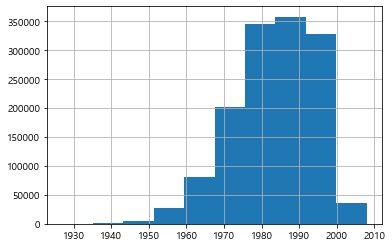

In [33]:
user_spec["birth_year"].hist()

In [34]:
user_spec["only_age"] = 2022 - user_spec["birth_year"]

**만으로 청소년(13-18세), 청년(19-29세), 중년(30-49세), 장년(50-64세), 노년(65세 이상)** / 청년기본법에 의거

In [35]:
user_spec["cat_age"] =  pd.cut(user_spec["only_age"],[12,18, 29, 49, 64,100], right=False, labels=['청소년', '청년', '중년', '장년', '노년']).astype(object)
user_spec["cat_age"]

0          중년
1          장년
2          청년
3          중년
4          청년
           ..
1394211    청년
1394212    노년
1394213    중년
1394214    중년
1394215    중년
Name: cat_age, Length: 1394216, dtype: object

In [36]:
user_spec.loc[user_spec["cat_age"].isna(),"cat_age"] = "Missing_age"

In [37]:
user_spec["cat_gender"] = "Missing_gender"
user_spec.loc[user_spec["gender"] == 1,"cat_gender"] = "남성"
user_spec.loc[user_spec["gender"] == 0,"cat_gender"] = "여성"

나이 성별 범주화 완료

**청소년 제거**\
법적으로 대출을 받을 수 없는 나이이며, 실제로 대출을 받은 내역이 없다.

In [38]:
user_spec = user_spec[-(user_spec["cat_age"] == "청소년")]

### 개인정보(yearly_income, income_type, employment_type, houseown_type, desired_amount, purpose) 결측치 대체

In [39]:
#income_type, employment_type, houseown_type, desired_amount, purpose 결측 85개
#yearly_income 결측 85개
user_info_na = user_spec[(user_spec["income_type"].isna()) & (user_spec["employment_type"].isna()) & 
         (user_spec["houseown_type"].isna()) & (user_spec["desired_amount"].isna()) & 
                (user_spec["purpose"].isna()) & (user_spec["yearly_income"].isna())]
user_info_na.head()

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,only_age,cat_age,cat_gender
5353,129515,135984,1974.0,1.0,2022-06-13 18:26:44,750.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,4.0,67000000.0,48.0,중년,남성
8864,1468193,151012,1996.0,1.0,2022-06-16 16:34:35,810.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2.0,6000000.0,26.0,청년,남성
17484,1234909,596908,1996.0,0.0,2022-06-16 16:28:10,640.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,3.0,36000000.0,26.0,청년,여성
17552,1068316,142003,1976.0,0.0,2022-06-16 16:28:59,770.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,중년,여성
20510,2082836,827892,1993.0,1.0,2022-06-16 16:30:46,940.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,3.0,61000000.0,29.0,중년,남성


**위의 85개 경우는 전부 loan_result에 없는 application_id 이다.\
6개의 개인정보 변수가 결측이라면 대출을 신청할 수 없음**

In [40]:
l_list = []
for i in user_info_na["application_id"]:
    l_list.append(len(loan_result[loan_result["application_id"] == i]))

In [41]:
np.unique(l_list)

array([0])

**따라서 삭제가 적절하다고 판단**

#### yearly_income만 결측인 경우

In [42]:
# yearly_income만 결측인 값 5개
user_spec[(-user_spec["purpose"].isna()) & (user_spec["yearly_income"].isna())]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,only_age,cat_age,cat_gender
165422,1026915,861363,1995.0,1.0,2022-06-30 21:11:51,NaN,NaN,OTHERINCOME,NaT,기타,전월세,5250000.0,생활비,0.0,0.0,NaN,NaN,27.0,청년,남성
233316,2045613,702899,1995.0,1.0,2022-06-30 18:37:04,520.0,NaN,FREELANCER,2022-06-01,기타,전월세,5250000.0,전월세보증금,0.0,0.0,1.0,1000000.0,27.0,청년,남성
597591,391560,329226,1996.0,0.0,2022-06-30 19:27:28,590.0,NaN,OTHERINCOME,NaT,기타,전월세,20250000.0,생활비,0.0,0.0,9.0,27000000.0,26.0,청년,여성
597613,341149,670502,1981.0,1.0,2022-06-30 21:32:18,930.0,NaN,OTHERINCOME,NaT,기타,기타가족소유,6250000.0,사업자금,0.0,0.0,1.0,3000000.0,41.0,중년,남성
971960,1330905,771592,2003.0,1.0,2022-06-30 18:57:05,750.0,NaN,OTHERINCOME,NaT,기타,자가,3250000.0,생활비,0.0,0.0,1.0,3000000.0,19.0,청년,남성


- 전부 6월 30일에 생성되었다는 특징이 있음, 이유는 발견 못함 -> 데이터를 잘라오면서 생긴 문제일 수 있음 Q&A 9월 20일 4번

yearly_income 기준 결측 행 삭제

- application_id : 341149 만 loan_result에 행이 존재

In [43]:
loan_result[loan_result["application_id"] == 341149]

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,log_loan_limit
4495392,341149,2022-06-30 21:32:20,64,254,45250000.0,10.3,NaN,17.627713
4495394,341149,2022-06-30 21:32:19,13,262,35250000.0,16.4,NaN,17.377976
4495395,341149,2022-06-30 21:32:19,38,113,5250000.0,19.5,NaN,15.473739
4495396,341149,2022-06-30 21:32:19,14,128,15250000.0,12.5,NaN,16.540090
4495399,341149,2022-06-30 21:32:19,29,265,10250000.0,9.1,NaN,16.142788
4495401,341149,2022-06-30 21:32:19,57,71,23250000.0,15.4,NaN,16.961816


In [44]:
user_spec[user_spec["user_id"] == 670502]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,only_age,cat_age,cat_gender
566158,1746224,670502,1981.0,1.0,2022-06-30 22:41:11,930.0,0.0,OTHERINCOME,NaT,기타,기타가족소유,6250000.0,사업자금,0.0,0.0,1.0,3000000.0,41.0,중년,남성
597613,341149,670502,1981.0,1.0,2022-06-30 21:32:18,930.0,NaN,OTHERINCOME,NaT,기타,기타가족소유,6250000.0,사업자금,0.0,0.0,1.0,3000000.0,41.0,중년,남성


In [45]:
#같은 user의 다른 application을 이용하여 대체, 생성일시를 제외한 모든 조건이 동일하기 때문에 연소득 대체 가능하다고 판단
user_spec.loc[user_spec["application_id"] == 341149, "yearly_income"] = user_spec.loc[user_spec["user_id"] == 670502,"yearly_income"].mean()

In [46]:
#연소득 기준 결측인 행 삭제
user_spec = user_spec[-user_spec["yearly_income"].isna()]

In [47]:
#yearly_income, desired_amount 로그 변환 변수 추가
user_spec["log_yearly_income"] = np.log(user_spec["yearly_income"]+1)
user_spec["log_desired_amount"] = np.log(user_spec["desired_amount"])

### 입사년도 결측치 대체
입사년도 - 출생년도 : 몇 살에 입사를 했는가

생성년도 - 입사년도 : 입사한지 얼마나 지났는가 ( = 경력)

Quantile을 이용해 범주화

In [48]:
user_spec["aft_enter_time"] = (user_spec["insert_time"] - user_spec["company_enter_month"]).dt.days / 365

user_spec["cat_aft_enter_time"] =  pd.cut(user_spec["aft_enter_time"],
                                          [user_spec["aft_enter_time"].describe()["min"],
                                           user_spec["aft_enter_time"].describe()["25%"],
                                           user_spec["aft_enter_time"].describe()["50%"],
                                           user_spec["aft_enter_time"].describe()["75%"],
                                           user_spec["aft_enter_time"].describe()["max"]+1], right=False, labels=['0~25','25~50', '50~75','75~100']).astype(object)

user_spec["cat_aft_enter_time"] = user_spec["cat_aft_enter_time"].fillna("cat_aft_enter_NA")

In [49]:
user_spec["bef_enter_time"] = (user_spec["company_enter_month"].dt.year - user_spec["birth_year"])

user_spec["cat_bef_enter_time"] =  pd.cut(user_spec["bef_enter_time"],
                                          [user_spec["bef_enter_time"].describe()["min"],
                                           user_spec["bef_enter_time"].describe()["25%"],
                                           user_spec["bef_enter_time"].describe()["50%"],
                                           user_spec["bef_enter_time"].describe()["75%"],
                                           user_spec["bef_enter_time"].describe()["max"]+1], right=False, labels=['0~25','25~50', '50~75','75~100']).astype(object)

user_spec["cat_bef_enter_time"] = user_spec["cat_bef_enter_time"].fillna("cat_bef_enter_NA")

In [50]:
user_spec.value_counts(["cat_bef_enter_time","cat_aft_enter_time"]).reset_index()

,cat_bef_enter_time,cat_aft_enter_time,0
0,cat_bef_enter_NA,cat_aft_enter_NA,171623
1,75~100,25~50,90929
2,25~50,75~100,90184
3,75~100,50~75,89814
4,50~75,50~75,88934
5,0~25,75~100,85008
6,25~50,0~25,83215
7,75~100,0~25,82461
8,50~75,25~50,76671
9,50~75,75~100,76355


### personal_rehabilitation_yn, personal_rehabilitation_complete_yn

- 개인 회생자 신청 여부(0:개인회생자 X, 1:개인회생자O)
- 개인 회생 완료 여부(personal_rehabilitation_yn == 1인 사람들 중, 0:납입중, 1:완료)

4월18일에 개인회생자 전용 대출이 생김

4월18일 이전 데이터에서는 전부 (NA, NA)

상식적으로 존재 가능한 경우의 수 : (0,NA), (1,0), (1,1)

이상값인 0,0 or 0,1 는 아마도 개인회생자 여부를 체크 한 후, 다시 해제한 경우일 가능성이 있음!

-> 그렇다면 전부 0, NA로 대체하는 것이 옳음

In [51]:
user_spec.loc[(user_spec["personal_rehabilitation_yn"] == 0) & (-user_spec["personal_rehabilitation_complete_yn"].isna()), "personal_rehabilitation_complete_yn"] = np.nan

In [52]:
print("NA,NA : ", user_spec[(user_spec["personal_rehabilitation_yn"].isna()) & (user_spec["personal_rehabilitation_complete_yn"].isna())].shape)
print("1,NA :",user_spec[(user_spec["personal_rehabilitation_yn"] == 1) & (user_spec["personal_rehabilitation_complete_yn"].isna())].shape)
print("1,0 or 1,1 :",user_spec[(user_spec["personal_rehabilitation_yn"] == 1) & (-user_spec["personal_rehabilitation_complete_yn"].isna())].shape)
print("0,NA :",user_spec[(user_spec["personal_rehabilitation_yn"] == 0) & (user_spec["personal_rehabilitation_complete_yn"].isna())].shape)
print("0,0 or 0,1 :",user_spec[(user_spec["personal_rehabilitation_yn"] == 0) & (-user_spec["personal_rehabilitation_complete_yn"].isna())].shape)

NA,NA :  (587360, 26)
1,NA : (0, 26)
1,0 or 1,1 : (12705, 26)
0,NA : (794005, 26)
0,0 or 0,1 : (0, 26)


**개인회생 관련 변수를 하나의 변수로 범주화**

In [53]:
user_spec["rehabilitation"] = "rehabilitation_not"
user_spec.loc[(user_spec["personal_rehabilitation_yn"] == 1) & (user_spec["personal_rehabilitation_complete_yn"] == 0),"rehabilitation"] = "rehabilitation"
user_spec.loc[(user_spec["personal_rehabilitation_yn"] == 1) & (user_spec["personal_rehabilitation_complete_yn"] == 1),"rehabilitation"] = "rehabilitation_completed"
user_spec.loc[(user_spec["personal_rehabilitation_yn"].isna()) & (user_spec["personal_rehabilitation_complete_yn"].isna()),"rehabilitation"] = "rehabilitation_NA"

rehabilitation_not : 개인회생자가 아님\
rehabilitation : 개인회생자이며, 납입중임\
rehabilitation_completed : 개인회생자이며, 납입 완료했음\
rehabilitation_NA : 아마도 앱 버전의 이유로 선택란이 없었을 것. 즉, 알 수 없음

In [54]:
user_spec["rehabilitation"].value_counts()

rehabilitation_not          794005
rehabilitation_NA           587360
rehabilitation               11358
rehabilitation_completed      1347
Name: rehabilitation, dtype: int64

#### 집단간 신용 점수 차이가 있는지 검정

In [55]:
rehabilitation_not = user_spec[(user_spec["rehabilitation"] == "rehabilitation_not") & (user_spec["credit_score"].notna())].copy()
rehabilitation = user_spec[(user_spec["rehabilitation"] == "rehabilitation") & (user_spec["credit_score"].notna())].copy()
rehabilitation_completed = user_spec[(user_spec["rehabilitation"] == "rehabilitation_completed") & (user_spec["credit_score"].notna())].copy()

In [56]:
#집단 크기 확인
rehabilitation_not_c_score = rehabilitation_not["credit_score"]
rehabilitation_c_score = rehabilitation["credit_score"]
rehabilitation_completed_c_score = rehabilitation_completed["credit_score"]

print("<size>")
print("rehabilitation_not : ", len(rehabilitation_not_c_score))
print("rehabilitation : ", len(rehabilitation_c_score))
print("rehabilitation_completed : ", len(rehabilitation_completed_c_score))

<size>
rehabilitation_not :  745799
rehabilitation :  10106
rehabilitation_completed :  1234


Text(0.5, 1.0, 'rehabilitation_completed')

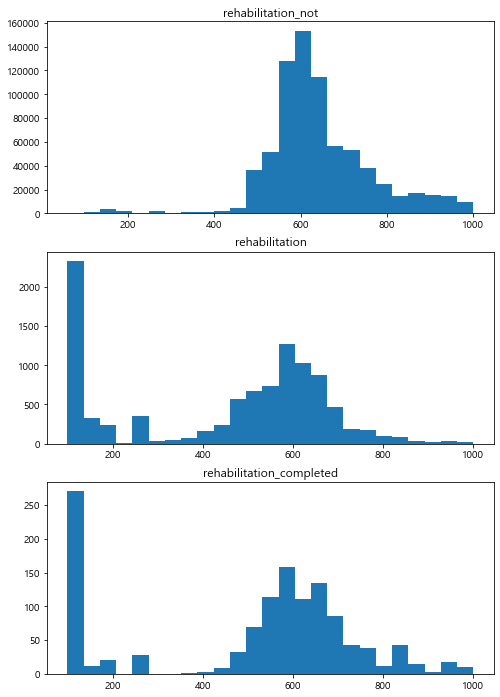

In [57]:
#정규성 확인 hist
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(rehabilitation_not_c_score,bins=25)
plt.title("rehabilitation_not")
plt.subplot(3,1,2)
plt.hist(rehabilitation_c_score,25)
plt.title("rehabilitation")
plt.subplot(3,1,3)
plt.hist(rehabilitation_completed_c_score,bins=25)
plt.title("rehabilitation_completed")

정규성검정 1 : Shapiro test

 - 전부 기각 (= 정규성을 만족하지 않음)

In [58]:
print("H0 : 정규성을 충족한다")
print("rehabilitation_not :",shapiro(rehabilitation_not_c_score))
print("rehabilitation :",shapiro(rehabilitation_c_score))
print("rehabilitation_completed :",shapiro(rehabilitation_completed_c_score))

H0 : 정규성을 충족한다
rehabilitation_not : ShapiroResult(statistic=0.927108108997345, pvalue=0.0)
rehabilitation : ShapiroResult(statistic=0.8658428192138672, pvalue=0.0)
rehabilitation_completed : ShapiroResult(statistic=0.8606172800064087, pvalue=1.0479840117100609e-31)


정규성검정 2 : D’Agostino’s K^2 Test
 - 전부 기각 (= 정규성을 만족하지 않음)

In [59]:
print("H0 : 정규성을 충족한다")
print("rehabilitation_not :",normaltest(rehabilitation_not_c_score))
print("rehabilitation :",normaltest(rehabilitation_c_score))
print("rehabilitation_completed :",normaltest(rehabilitation_completed_c_score))

H0 : 정규성을 충족한다
rehabilitation_not : NormaltestResult(statistic=48567.60090796639, pvalue=0.0)
rehabilitation : NormaltestResult(statistic=13294.510090538757, pvalue=0.0)
rehabilitation_completed : NormaltestResult(statistic=214.14520170290868, pvalue=3.154716136195898e-47)


정규성검정 3 : Kolmogorove-Smirnov test
 - 전부 기각 (= 정규성을 만족하지 않음)

In [60]:

print("H0 : 정규성을 충족한다")
print("rehabilitation_not :",kstest(rehabilitation_not_c_score, "norm"))
print("rehabilitation :",kstest(rehabilitation_c_score, "norm"))
print("rehabilitation_completed :",kstest(rehabilitation_completed_c_score, "norm"))

H0 : 정규성을 충족한다
rehabilitation_not : KstestResult(statistic=1.0, pvalue=0.0)
rehabilitation : KstestResult(statistic=1.0, pvalue=0.0)
rehabilitation_completed : KstestResult(statistic=1.0, pvalue=0.0)


결론 : 4개의 집단 모두 정규성을 만족하지 않음.
    
--> 비모수적 방법인 맨 휘트니 U test(우측검정)사용

In [61]:
#맨휘트니 U test
print("rehabilitation_not vs rehabilitation : ",mannwhitneyu(rehabilitation_not_c_score, rehabilitation_c_score, alternative='greater'))
#rehabilitation_not > rehabilitation

print("rehabilitation_not vs rehabilitation_completed : ",mannwhitneyu(rehabilitation_not_c_score, rehabilitation_completed_c_score, alternative='greater'))
#rehabilitation_not > rehabilitation_completed

print("rehabilitation vs rehabilitation_completed : ",mannwhitneyu(rehabilitation_c_score, rehabilitation_completed_c_score, alternative='greater'))
#rehabilitation < rehabilitation_completed

rehabilitation_not vs rehabilitation :  MannwhitneyuResult(statistic=5597927668.0, pvalue=0.0)
rehabilitation_not vs rehabilitation_completed :  MannwhitneyuResult(statistic=588407278.5, pvalue=8.94387655845642e-65)
rehabilitation vs rehabilitation_completed :  MannwhitneyuResult(statistic=5238011.5, pvalue=1.0)


신용 점수 큰 순서

rehabilitation_not(개인회생아님) > rehabilitation_completed(개인회생 납부완료) > rehabilitation(개인회생중)

### existing_loan_cnt, existing_loan_amt 결측치 대체

먼저, 기대출 횟수, 잔액이 변동된 경우는 없다.

In [62]:
user_loan_amt_min = user_spec.groupby("user_id").min()["existing_loan_amt"]
user_loan_amt_max = user_spec.groupby("user_id").max()["existing_loan_amt"]
user_loan_amt_min[user_loan_amt_min != user_loan_amt_max].max()

nan

In [63]:
user_loan_cnt_min = user_spec.groupby("user_id").min()["existing_loan_cnt"]
user_loan_cnt_max = user_spec.groupby("user_id").max()["existing_loan_cnt"]
user_loan_cnt_min[user_loan_cnt_min != user_loan_cnt_max].max()

nan

#### 기대출 횟수와 잔액의 NA여부를 바탕으로 그룹 형성

- 횟수가 0인 경우는 없음
- 잔액이 NA인 경우는 횟수가 NA또는 1
- 잔액이 0인 경우 존재

NA NA : 대출 경험 없음

1 NA : 이상값 ->    문의 결과 *-특별한 의미는 없습니다. 대출 금액을 못받아오는 케이스들이 있습니다.-*

!NA 0 : 이상값 ->     문의 결과 *-반올림 과정에서 0이 된 경우가 맞습니다.-*

!NA !NA : 기대출 보유자

In [64]:
loan_na_na = user_spec[(user_spec["existing_loan_cnt"].isna()) & (user_spec["existing_loan_amt"].isna())]
loan_na_na.value_counts("existing_loan_cnt")

Series([], dtype: int64)

In [65]:
loan_notna_na = user_spec[-(user_spec["existing_loan_cnt"].isna()) & (user_spec["existing_loan_amt"].isna())]
loan_notna_na.value_counts("existing_loan_cnt")

existing_loan_cnt
1.0    115187
dtype: int64

In [66]:
loan_notna_notna = user_spec[-(user_spec["existing_loan_cnt"].isna()) & (-user_spec["existing_loan_amt"].isna())]
loan_notna_notna.value_counts("existing_loan_cnt")

existing_loan_cnt
3.0      155923
2.0      145538
4.0      144384
1.0      126369
5.0      124044
          ...  
81.0          1
169.0         1
176.0         1
71.0          1
67.0          1
Length: 100, dtype: int64

In [67]:
loan_notna_0 = user_spec[-(user_spec["existing_loan_cnt"].isna()) & (user_spec["existing_loan_amt"]==0)]
loan_notna_0.value_counts("existing_loan_cnt")

existing_loan_cnt
1.0     4636
2.0      409
3.0       68
4.0       11
13.0       3
9.0        1
6.0        1
5.0        1
dtype: int64

In [68]:
user_spec["existing_loan_cnt_2"] = user_spec["existing_loan_cnt"].copy()
user_spec["existing_loan_amt_2"] = user_spec["existing_loan_amt"].copy()

med_cnt_1 = user_spec.loc[user_spec["existing_loan_cnt_2"]==1,"existing_loan_amt_2"].median()

user_spec.loc[-user_spec["existing_loan_amt_2"].isna(),"existing_loan_amt_2"] += 250000 # 반올림 과정 중 0으로 바뀐 값을 위해

user_spec.loc[-(user_spec["existing_loan_amt_2"].isna()) & (user_spec["existing_loan_amt_2"].isna()),"existing_loan_amt_2"] = med_cnt_1

user_spec["existing_loan_cnt_2"] = user_spec["existing_loan_cnt_2"].fillna(0)
user_spec["existing_loan_amt_2"] = user_spec["existing_loan_amt_2"].fillna(0)
user_spec["log_existing_loan_amt_2"] = np.log(user_spec["existing_loan_amt_2"]+1)

In [69]:
user_spec.isna().sum()

application_id                               0
user_id                                      0
birth_year                                9723
gender                                    9723
insert_time                                  0
credit_score                            105054
yearly_income                                0
income_type                                  0
company_enter_month                     171623
employment_type                              0
houseown_type                                0
desired_amount                               0
purpose                                      0
personal_rehabilitation_yn              587360
personal_rehabilitation_complete_yn    1381365
existing_loan_cnt                       198507
existing_loan_amt                       313694
only_age                                  9723
cat_age                                      0
cat_gender                                   0
log_yearly_income                            0
log_desired_a

In [70]:
user_spec1_1 = user_spec.drop(["company_enter_month","personal_rehabilitation_yn","personal_rehabilitation_complete_yn",
                               "existing_loan_cnt","existing_loan_amt", "only_age","aft_enter_time", "bef_enter_time"],axis = 1)
user_spec1_1.to_csv("user_spec1_1.csv", index = False)

In [71]:
user_spec1_2 = user_spec.drop(["personal_rehabilitation_yn","personal_rehabilitation_complete_yn",
               "existing_loan_cnt","existing_loan_amt", "only_age","aft_enter_time", "bef_enter_time"],axis = 1)
user_spec1_2.to_csv("user_spec1_2.csv", index=False)

### Credit Score

In [72]:
user_spec2 = user_spec.drop(["birth_year","gender","company_enter_month","personal_rehabilitation_yn","personal_rehabilitation_complete_yn",
               "existing_loan_cnt","existing_loan_amt", "only_age","aft_enter_time", "bef_enter_time"],axis = 1)

In [73]:
user_spec2.to_csv("user_spec2.csv", index = False)

In [74]:
user_spec2.isna().sum()

application_id                  0
user_id                         0
insert_time                     0
credit_score               105054
yearly_income                   0
income_type                     0
employment_type                 0
houseown_type                   0
desired_amount                  0
purpose                         0
cat_age                         0
cat_gender                      0
log_yearly_income               0
log_desired_amount              0
cat_aft_enter_time              0
cat_bef_enter_time              0
rehabilitation                  0
existing_loan_cnt_2             0
existing_loan_amt_2             0
log_existing_loan_amt_2         0
dtype: int64

#### credit score가 NA가 아닌 행이 존재하는 user_id

**EX)**\
NA --> 810으로 대체\
NA --> 810으로 대체\
810\
810\
820

In [75]:
credit_na_ids = user_spec2[user_spec2["credit_score"].isna()]["user_id"].unique()

In [76]:
credit_not_na_ids = user_spec2[(user_spec2["user_id"].isin(credit_na_ids)) & (-user_spec2["credit_score"].isna())]["user_id"].unique()
credit_not_na_ids

array([553686,  93773, 131488, ..., 140245, 140769, 421807], dtype=int64)

In [77]:
df1 = user_spec2[user_spec2["user_id"].isin(credit_not_na_ids)].copy()
df2 = user_spec2[-user_spec2["user_id"].isin(credit_not_na_ids)].copy()

In [78]:
len(df1) + len(df2) == len(user_spec2)

True

In [79]:
df1_1 = pd.DataFrame()
for i in tqdm_notebook(credit_not_na_ids):
    df1_1 = df1_1.append(df1[df1["user_id"] == i].sort_values("insert_time").fillna(method='bfill'))

  0%|          | 0/10922 [00:00<?, ?it/s]

In [80]:
df1_1.isna().sum()

application_id             0
user_id                    0
insert_time                0
credit_score               0
yearly_income              0
income_type                0
employment_type            0
houseown_type              0
desired_amount             0
purpose                    0
cat_age                    0
cat_gender                 0
log_yearly_income          0
log_desired_amount         0
cat_aft_enter_time         0
cat_bef_enter_time         0
rehabilitation             0
existing_loan_cnt_2        0
existing_loan_amt_2        0
log_existing_loan_amt_2    0
dtype: int64

In [81]:
len(df1_1) + len(df2) == len(user_spec2)

True

처리 후 병합

In [82]:
user_spec3 = pd.concat([df1_1,df2]).sort_index()

In [83]:
user_spec3.isna().sum()

application_id                 0
user_id                        0
insert_time                    0
credit_score               87464
yearly_income                  0
income_type                    0
employment_type                0
houseown_type                  0
desired_amount                 0
purpose                        0
cat_age                        0
cat_gender                     0
log_yearly_income              0
log_desired_amount             0
cat_aft_enter_time             0
cat_bef_enter_time             0
rehabilitation                 0
existing_loan_cnt_2            0
existing_loan_amt_2            0
log_existing_loan_amt_2        0
dtype: int64

In [84]:
user_spec3.to_csv("user_spec3.csv", index = False)
loan_result.to_csv("loan_result2.csv", index = False)

application_id 별 승인된 상품들의 한도, 금리에 대하여 통계량 값 추가

In [85]:
features = ['application_id','loan_rate','log_loan_limit']
loan_result_preprocess = loan_result[features].groupby('application_id').agg(['max', 'min', 'mean',"count"])

In [86]:
loan_result_preprocess.columns=[i[1]+'_'+i[0] for i in loan_result_preprocess.columns]
loan_result_preprocess = loan_result_preprocess.reset_index()

In [87]:
user_spec3_1 = pd.merge(user_spec3, loan_result_preprocess, how='left', on="application_id")

In [88]:
#loan_rate 관련 변수는 999
user_spec3_1.loc[:,loan_result_preprocess.columns[1:5]] = user_spec3_1.loc[:,loan_result_preprocess.columns[1:5]].fillna(999) 
#loan_limit 관련 변수는 -999
user_spec3_1.loc[:,loan_result_preprocess.columns[5:10]] = user_spec3_1.loc[:,loan_result_preprocess.columns[5:10]].fillna(-999) 
#개수는 0
user_spec3_1.loc[:,["count_loan_rate","count_log_loan_limit"]] = user_spec3_1.loc[:,["count_loan_rate","count_log_loan_limit"]].fillna(0)

In [89]:
user_spec3_1.to_csv("user_spec3_1.csv",index=False)

#### MissForest

##### 신용점수 모델 검증

In [90]:
train_set = user_spec3_1[-user_spec3_1["credit_score"].isna()].copy()

In [91]:
np.random.seed(1234)
#랜덤하게 validset으로 사용할 user_id 선택
valid_ids = np.random.choice(train_set["user_id"], int(0.01*len(user_spec3)))
true_credit = train_set.loc[train_set["user_id"].isin(valid_ids), "credit_score"].copy()
train_set.loc[train_set["user_id"].isin(valid_ids), "credit_score"] = np.nan

In [92]:
RS = 100
train_set_2 = train_set.copy()

In [93]:
train_set.drop("application_id",axis=1,inplace = True)
train_set.drop("user_id",axis=1,inplace = True)

#train_set["user_id"] = train_set["user_id"].astype('category')
train_set["cat_age"] = train_set["cat_age"].astype('category')
train_set["cat_aft_enter_time"] = train_set["cat_aft_enter_time"].astype('category')
train_set["cat_bef_enter_time"] = train_set["cat_bef_enter_time"].astype('category')
train_set["income_type"] = train_set["income_type"].astype('category')
train_set["employment_type"] = train_set["rehabilitation"].astype('category')
train_set["houseown_type"] = train_set["houseown_type"].astype('category')
train_set["purpose"] = train_set["purpose"].astype('category')
train_set["cat_gender"] = train_set["cat_gender"].astype('category')
train_set["rehabilitation"] = train_set["rehabilitation"].astype('category')
train_set['insert_time'] = pd.to_numeric(train_set['insert_time'])

In [94]:
## categorial label Encoder
cat_t = train_set[train_set.select_dtypes(['category']).columns.tolist()]

for col in train_set.select_dtypes(['category']).columns.tolist():
    le = preprocessing.LabelEncoder()
    le.fit(cat_t[col])
    train_set[col]=le.transform(cat_t[col])
    train_set[col] = train_set[col].astype('category')

In [95]:
fac_var = train_set.select_dtypes(['category']).columns

In [96]:
UseCols = train_set.columns.tolist()
cat_var = [idx for idx , col in enumerate(UseCols) if col in fac_var]
MISSForest_algo = MissForest(max_iter = 20, verbose = 0, n_jobs  = -1 , max_depth=10)
MISSForest_algo.fit(X =train_set  , cat_vars= cat_var)
Tr_imputed = MISSForest_algo.transform(train_set)
Tr_imputed = pd.DataFrame(Tr_imputed, columns= UseCols)                          
Tr_imputed[fac_var] = Tr_imputed[fac_var].astype(int)

Iteration: 0
Iteration: 1
Iteration: 2


In [97]:
Tr_imputed.index = train_set.index
predict_credit = Tr_imputed.loc[train_set["credit_score"].isna(),"credit_score"]

In [98]:
#예측 신용점수 RMSE ver2
print(np.sqrt(np.mean((true_credit - predict_credit)**2)))

67.16435073818369


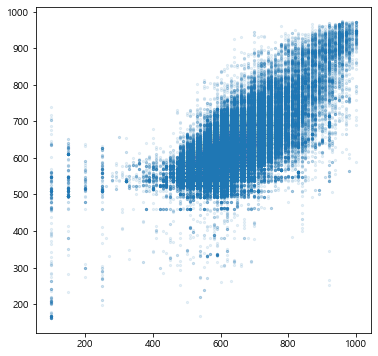

In [99]:
plt.figure(figsize=(6,6))
plt.scatter(true_credit, predict_credit, s=5,alpha=0.1)

##### 신용점수 모델링 및 예측

In [100]:
#!pip install missingpy

In [101]:
RS = 100

In [102]:
credit_na_id = user_spec3_1.loc[user_spec3_1["credit_score"].isna(), "user_id"].unique()

In [103]:
user_spec3_1["insert_time"] = pd.to_datetime(user_spec3_1["insert_time"])

In [104]:
user_spec4 = user_spec3_1.copy()
user_spec4.drop(["user_id","application_id"],axis=1,inplace = True)
user_spec4["cat_age"] = user_spec4["cat_age"].astype('category')
user_spec4["cat_aft_enter_time"] = user_spec4["cat_aft_enter_time"].astype('category')
user_spec4["cat_bef_enter_time"] = user_spec4["cat_bef_enter_time"].astype('category')
user_spec4["income_type"] = user_spec4["income_type"].astype('category')
user_spec4["employment_type"] = user_spec4["rehabilitation"].astype('category')
user_spec4["houseown_type"] = user_spec4["houseown_type"].astype('category')
user_spec4["purpose"] = user_spec4["purpose"].astype('category')
user_spec4["cat_gender"] = user_spec4["cat_gender"].astype('category')
user_spec4["rehabilitation"] = user_spec4["rehabilitation"].astype('category')
user_spec4['insert_time'] = pd.to_numeric(user_spec4['insert_time'])

In [105]:
## categorial label Encoder
cat_t = user_spec4[user_spec4.select_dtypes(['category']).columns.tolist()]

for col in user_spec4.select_dtypes(['category']).columns.tolist():
    le = preprocessing.LabelEncoder()
    le.fit(cat_t[col])
    user_spec4[col]=le.transform(cat_t[col])
    user_spec4[col] = user_spec4[col].astype('category')

In [106]:
fac_var = user_spec4.select_dtypes(['category']).columns

In [107]:
UseCols = user_spec4.columns.tolist()
cat_var = [idx for idx , col in enumerate(UseCols) if col in fac_var]
MISSForest_algo = MissForest(max_iter = 20, verbose = 0, n_jobs  = -1 , max_depth=10)
MISSForest_algo.fit(X =user_spec4  , cat_vars= cat_var)
Tr_imputed = MISSForest_algo.transform(user_spec4)
Tr_imputed = pd.DataFrame(Tr_imputed, columns= UseCols)                          
Tr_imputed[fac_var] = Tr_imputed[fac_var].astype(int)

Iteration: 0
Iteration: 1
Iteration: 2


In [108]:
Tr_imputed["user_id"] = user_spec3_1["user_id"]

In [109]:
tmp = Tr_imputed.loc[Tr_imputed["user_id"].isin(credit_na_id),["user_id","credit_score"]].groupby("user_id",as_index=False).mean()[["user_id","credit_score"]]
tmp["credit_score"] = round(tmp["credit_score"], -1)
tmp.rename(columns={"credit_score" : "credit_score2"}, inplace = True)

user_spec5 = pd.merge(user_spec3_1, tmp, how='left', on = "user_id")
user_spec5['credit_score_last'] = np.nansum((user_spec5["credit_score"], user_spec5["credit_score2"]), axis=0)

In [110]:
user_spec5.drop(["credit_score","credit_score2"],axis=1,inplace = True)

In [111]:
user_spec5.isna().sum()

application_id             0
user_id                    0
insert_time                0
yearly_income              0
income_type                0
employment_type            0
houseown_type              0
desired_amount             0
purpose                    0
cat_age                    0
cat_gender                 0
log_yearly_income          0
log_desired_amount         0
cat_aft_enter_time         0
cat_bef_enter_time         0
rehabilitation             0
existing_loan_cnt_2        0
existing_loan_amt_2        0
log_existing_loan_amt_2    0
max_loan_rate              0
min_loan_rate              0
mean_loan_rate             0
count_loan_rate            0
max_log_loan_limit         0
min_log_loan_limit         0
mean_log_loan_limit        0
count_log_loan_limit       0
credit_score_last          0
dtype: int64

In [112]:
user_spec5.to_csv("user_spec5.csv",index=False)

#### 선형 회귀 어쩌고 (배정민)

In [113]:
user_spec5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394070 entries, 0 to 1394069
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   application_id           1394070 non-null  int64         
 1   user_id                  1394070 non-null  int64         
 2   insert_time              1394070 non-null  datetime64[ns]
 3   yearly_income            1394070 non-null  float64       
 4   income_type              1394070 non-null  object        
 5   employment_type          1394070 non-null  object        
 6   houseown_type            1394070 non-null  object        
 7   desired_amount           1394070 non-null  float64       
 8   purpose                  1394070 non-null  object        
 9   cat_age                  1394070 non-null  object        
 10  cat_gender               1394070 non-null  object        
 11  log_yearly_income        1394070 non-null  float64       
 12  

In [114]:
loan_result_yn_df = loan_result.groupby("application_id",as_index=False).max()[["application_id","is_applied"]]
user_spec6 = pd.merge(user_spec5,loan_result_yn_df,how='left',on='application_id')

#### loan_reslut에 없는 application_id는 버리자

In [115]:
#승인 상품이 없는 application_id는 학습에 사용하지 않는다.
user_spec6 = user_spec6[user_spec6["mean_loan_rate"] != 999]

In [116]:
user_spec6["time_rank"] = user_spec6.groupby("user_id").rank(ascending=True)["insert_time"]

In [117]:
user_spec6 = user_spec6.drop(["yearly_income","desired_amount","count_log_loan_limit"],axis=1)

In [118]:
user_spec6.isna().sum()

application_id                  0
user_id                         0
insert_time                     0
income_type                     0
employment_type                 0
houseown_type                   0
purpose                         0
cat_age                         0
cat_gender                      0
log_yearly_income               0
log_desired_amount              0
cat_aft_enter_time              0
cat_bef_enter_time              0
rehabilitation                  0
existing_loan_cnt_2             0
existing_loan_amt_2             0
log_existing_loan_amt_2         0
max_loan_rate                   0
min_loan_rate                   0
mean_loan_rate                  0
count_loan_rate                 0
max_log_loan_limit              0
min_log_loan_limit              0
mean_log_loan_limit             0
credit_score_last               0
is_applied                 239865
time_rank                       0
dtype: int64

In [119]:
user_spec6.to_csv("user_spec6.csv",index=False)

In [120]:
loan_result3 = pd.merge(loan_result,loan_result_yn_df.rename(columns={'is_applied':'is_applied_tot'}),how='left',on='application_id')
loan_result4 = pd.merge(loan_result3, user_spec6[["user_id","application_id"]], how="left", on="application_id")

In [121]:
loan_result4.to_csv('loan_result4.csv',index=False)

### Validation Set 분리

In [122]:
loan_result_df = loan_result4[loan_result4["is_applied"].notna()]
loan_result_test = loan_result4[loan_result4["is_applied"].isna()]

In [123]:
user_spec6_valid = user_spec6[(user_spec6["insert_time"] >= '2022-05-10') & (user_spec6["insert_time"] < '2022-06-01')]
user_spec6_train = user_spec6[user_spec6["insert_time"] < '2022-05-10']
user_spec6_test = user_spec6[user_spec6["insert_time"] >= '2022-06-01']

In [124]:
user_spec6_valid.to_csv("user_spec6_valid.csv",index=False)
user_spec6_train.to_csv("user_spec6_train.csv",index=False)
user_spec6_test.to_csv("user_spec6_test.csv",index=False)
loan_result_df.to_csv("loan_result_df.csv",index=False)
loan_result_test.to_csv("loan_result_test.csv",index=False)

In [125]:
print(user_spec6_train.shape)
print(user_spec6_valid.shape)

(541881, 27)
(186981, 27)


In [126]:
y_train = user_spec6_train["is_applied"].copy()
x_train = user_spec6_train.copy()

y_valid = user_spec6_valid["is_applied"].copy()
x_valid = user_spec6_valid.copy()

# 모델링 1

### Catboost

In [127]:
x_train.columns

Index(['application_id', 'user_id', 'insert_time', 'income_type',
       'employment_type', 'houseown_type', 'purpose', 'cat_age', 'cat_gender',
       'log_yearly_income', 'log_desired_amount', 'cat_aft_enter_time',
       'cat_bef_enter_time', 'rehabilitation', 'existing_loan_cnt_2',
       'existing_loan_amt_2', 'log_existing_loan_amt_2', 'max_loan_rate',
       'min_loan_rate', 'mean_loan_rate', 'count_loan_rate',
       'max_log_loan_limit', 'min_log_loan_limit', 'mean_log_loan_limit',
       'credit_score_last', 'is_applied', 'time_rank'],
      dtype='object')

In [128]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541881 entries, 153 to 1394069
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   application_id           541881 non-null  int64         
 1   user_id                  541881 non-null  int64         
 2   insert_time              541881 non-null  datetime64[ns]
 3   income_type              541881 non-null  object        
 4   employment_type          541881 non-null  object        
 5   houseown_type            541881 non-null  object        
 6   purpose                  541881 non-null  object        
 7   cat_age                  541881 non-null  object        
 8   cat_gender               541881 non-null  object        
 9   log_yearly_income        541881 non-null  float64       
 10  log_desired_amount       541881 non-null  float64       
 11  cat_aft_enter_time       541881 non-null  object        
 12  cat_bef_enter

In [129]:
weigt_m1 = compute_class_weight(class_weight = "balanced" , 
                     classes=[0,1], 
                     y = y_train)
weigt_m1

array([1.02160741, 0.97928767])

In [130]:
#fbeta-score 함수 생성
def my_fbeta_score(precision, recall, beta=1.5):
    return (1.0 + (beta ** 2)) * (precision * recall) / (((beta ** 2) * precision) + recall )

In [144]:
cat_01_BO_tuned = CatBoostClassifier(iterations = 2000, depth = 8,eval_metric = 'Logloss',cat_features=np.where(x_train.drop(["application_id","user_id","insert_time","is_applied","existing_loan_amt_2"],axis=1).dtypes != np.float)[0], 
                                   verbose = False, class_weights={0:weigt_m1[0],1:weigt_m1[1]},early_stopping_rounds = 200)
cat_01_BO_tuned.fit(x_train.drop(["application_id","user_id","insert_time","is_applied","existing_loan_amt_2"],axis=1),y_train, eval_set = evals)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [145]:
pred_cat_01_BO_valid = cat_01_BO_tuned.predict(x_valid.drop(["application_id","user_id","insert_time","is_applied","existing_loan_amt_2"],axis=1))
pred_cat_01_BO_train = cat_01_BO_tuned.predict(x_train.drop(["application_id","user_id","insert_time","is_applied","existing_loan_amt_2"],axis=1))

In [147]:
print("Train Set 결과")
print("accuracy_score : ",accuracy_score(y_train, pred_cat_01_BO_train))
print("recall_score : ",recall_score(y_train, pred_cat_01_BO_train))
print("precision_score : ",precision_score(y_train, pred_cat_01_BO_train))
print("f1_score : ",f1_score(y_train, pred_cat_01_BO_train))
f1_5 = my_fbeta_score(precision_score(y_train, pred_cat_01_BO_train), recall_score(y_train, pred_cat_01_BO_train))
print("f1.5_score : ",f1_5)

Train Set 결과
accuracy_score :  0.6905095399174358
recall_score :  0.7093623834807407
precision_score :  0.6921384135761542
f1_score :  0.70064456015151
f1.5_score :  0.7039720903256743


In [148]:
print("Valid Set 결과")
print("accuracy_score : ",accuracy_score(y_valid, pred_cat_01_BO_valid))
print("recall_score : ",recall_score(y_valid, pred_cat_01_BO_valid))
print("precision_score : ",precision_score(y_valid, pred_cat_01_BO_valid))
print("f1_score : ",f1_score(y_valid, pred_cat_01_BO_valid))
f1_5 = my_fbeta_score(precision_score(y_valid, pred_cat_01_BO_valid), recall_score(y_valid, pred_cat_01_BO_valid))
print("f1.5_score : ",f1_5)

Valid Set 결과
accuracy_score :  0.659425289200507
recall_score :  0.7020479000347102
precision_score :  0.677892902286743
f1_score :  0.6897589921223016
f1.5_score :  0.6944342365496629


변수 중요도

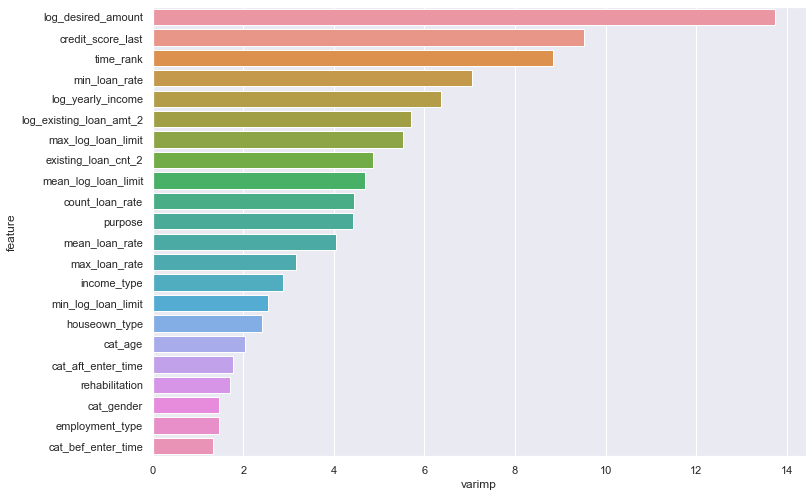

In [506]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
cat_feature_imp = pd.DataFrame([cat_01_BO_tuned.feature_names_ , cat_01_BO_tuned.feature_importances_]).T
cat_feature_imp.columns = ["feature","varimp"]
cat_feature_imp = cat_feature_imp.sort_values(by="varimp", ascending = False)
sns.barplot(y="feature", x="varimp",data = cat_feature_imp,)
plt.show()

In [519]:
#첫 조회일수록 신청을 많이해

In [518]:
for i in range(20):
    print(i+1, ":", x_train.loc[x_train["time_rank"] == i+1,"is_applied"].mean())

1 : 0.5109825488655573
2 : 0.5671068522441545
3 : 0.5579266767809806
4 : 0.5401594114040466
5 : 0.5108175307084276
6 : 0.4889536667689475
7 : 0.4716916780354707
8 : 0.4575984322109389
9 : 0.44118653736451796
10 : 0.4200939234381671
11 : 0.41007319623562216
12 : 0.39449348465741907
13 : 0.39056984367120523
14 : 0.3765376537653765
15 : 0.37224746592100666
16 : 0.37124289195775795
17 : 0.3682225365393682
18 : 0.3533916849015317
19 : 0.34308841843088417
20 : 0.35724533715925394


f1.5-score 최대인 구분값을 기준으로 예측

In [151]:
proba_cat_01_BO_valid = cat_01_BO_tuned.predict_proba(x_valid.drop(["application_id","user_id","insert_time","is_applied","existing_loan_amt_2"],axis=1))
proba_cat_01_BO_test = cat_01_BO_tuned.predict_proba(user_spec6_test.drop(["application_id","user_id","insert_time","is_applied","existing_loan_amt_2"],axis=1))

In [152]:
mypredictions_045 = []
mypredictions_040 = []
mypredictions_035 = []
mypredictions_030 = []
mypredictions_025 = []
mypredictions_020 = []
mypredictions_015 = []
mypredictions_010 = []

for i in proba_cat_01_BO_valid:
    if i[1] >= 0.45:
        mypredictions_045.append(1)
    else:
        mypredictions_045.append(0)
    
    if i[1] >= 0.4:
        mypredictions_040.append(1)
    else:
        mypredictions_040.append(0)
        
    if i[1] >= 0.35:
        mypredictions_035.append(1)
    else:
        mypredictions_035.append(0)
        
    if i[1] >= 0.3:
        mypredictions_030.append(1)
    else:
        mypredictions_030.append(0)
        
    if i[1] >= 0.25:
        mypredictions_025.append(1)
    else:
        mypredictions_025.append(0)
        
    if i[1] >= 0.2:
        mypredictions_020.append(1)
    else:
        mypredictions_020.append(0)
        
    if i[1] >= 0.15:
        mypredictions_015.append(1)
    else:
        mypredictions_015.append(0)
        
    if i[1] >= 0.1:
        mypredictions_010.append(1)
    else:
        mypredictions_010.append(0)

myprediction_lst = [pred_cat_01_BO_valid, mypredictions_045, mypredictions_040, mypredictions_035, mypredictions_030,
                    mypredictions_025, mypredictions_020, mypredictions_015, mypredictions_010]

In [153]:
max_i = 0
max_f1 = 0
for i in range(9):
    print("기준값 : ", 0.5-i*0.05)
    print("accuracy_score : ",accuracy_score(y_valid, myprediction_lst[i]))
    print("recall_score : ",recall_score(y_valid, myprediction_lst[i]))
    print("precision_score : ",precision_score(y_valid, myprediction_lst[i]))
    print("f1_score : ",f1_score(y_valid, myprediction_lst[i]))
    f1_5 = my_fbeta_score(precision_score(y_valid, myprediction_lst[i]), recall_score(y_valid, myprediction_lst[i]))
    print("f1.5_score : ",f1_5)
    print("\n")
    if f1_5 >= max_f1:
        max_f1 = f1_5
        max_i = 0.5-i*0.05

기준값 :  0.5
accuracy_score :  0.659425289200507
recall_score :  0.7020479000347102
precision_score :  0.677892902286743
f1_score :  0.6897589921223016
f1.5_score :  0.6944342365496629


기준값 :  0.45
accuracy_score :  0.6602863392537209
recall_score :  0.7856101552040462
precision_score :  0.654042718318348
f1_score :  0.7138145741910487
f1.5_score :  0.7398187200922994


기준값 :  0.4
accuracy_score :  0.6531840133489499
recall_score :  0.8540586106014777
precision_score :  0.6320614160630014
f1_score :  0.7264789991817315
f1.5_score :  0.7707623790119098


기준값 :  0.35
accuracy_score :  0.6388617025259251
recall_score :  0.9064312986562205
precision_score :  0.6114080446314494
f1_score :  0.7302477569249699
f1.5_score :  0.7892504644701122


기준값 :  0.3
accuracy_score :  0.6217957974339638
recall_score :  0.9440372886398571
precision_score :  0.5939625372817691
f1_score :  0.7291584482633158
f1.5_score :  0.7991171260878522


기준값 :  0.25
accuracy_score :  0.6031201031120809
recall_score :  0

In [154]:
prediction1_valid = []
for i in tqdm_notebook(proba_cat_01_BO_valid):
    if i[1] >= max_i:
        prediction1_valid.append(1)
    else:
        prediction1_valid.append(0)
x_valid["model1_pred"] = prediction1_valid            



prediction1_test = []
for i in tqdm_notebook(proba_cat_01_BO_test):
    if i[1] >= max_i:
        prediction1_test.append(1)
    else:
        prediction1_test.append(0)
user_spec6_test["model1_pred"] = prediction1_test   

  0%|          | 0/186981 [00:00<?, ?it/s]

  0%|          | 0/239865 [00:00<?, ?it/s]

모델 1을 바탕으로 1로 예측된 application_id에 대해서 모델 2 진행

In [155]:
x_valid2 = x_valid[x_valid["model1_pred"] == 1].copy()

In [163]:
model1_failed_app = user_spec6_test.loc[user_spec6_test["model1_pred"] == 0,"application_id"]
loan_result_test.loc[loan_result_test["application_id"].isin(model1_failed_app),"is_applied"] = 0

## 모델링2

In [304]:
applied_pred_appid_valid_lst = x_valid2["application_id"].unique()
applied_pred_appid_train_lst = x_train.loc[x_train["is_applied"]==1,"application_id"].unique()

In [409]:
loan_result_model2_valid = loan_result_df[loan_result_df["application_id"].isin(applied_pred_appid_valid_lst)]
#loan_result_model2_valid.to_csv("loan_result_model2_valid.csv",index=False)
loan_result_model2_train = loan_result_df[loan_result_df["application_id"].isin(applied_pred_appid_train_lst)]
#loan_result_model2_train.to_csv("loan_result_model2_train.csv",index=False)

In [410]:
#model2 test_set 생성
loan_result_model2_test = loan_result_test[loan_result_test["is_applied"].isna()]

### bank_id , product_id clustering

bank_id 기준

1금융권, 2금융권, 3금융권

가명화되지 않은 데이터에서는 알 수 있는 정보, 현재 가명화되어 있기 때문에 금리와 한도를 바탕으로 군집화한다.

In [411]:
bank_grp_loan = loan_result4.groupby("bank_id",as_index=False).mean()[["bank_id","loan_rate","loan_limit","log_loan_limit"]]

# StandardScaler
sdscaler = StandardScaler()
bank_grp_loan[["loan_rate","loan_limit","log_loan_limit"]] = sdscaler.fit_transform(bank_grp_loan[["loan_rate","loan_limit","log_loan_limit"]])

In [412]:
kmeans1 = KMeans(n_clusters=3,random_state=42)
kmeans1.fit(bank_grp_loan[["loan_rate","log_loan_limit"]])
bank_labels = kmeans1.labels_

In [413]:
bank_grp_loan["bank_label"] = bank_labels+1
bank_grp_loan["bank_label"] = bank_grp_loan["bank_label"].astype(object)
bank_grp_loan.head()

,bank_id,loan_rate,loan_limit,log_loan_limit,bank_label
0,1,-0.064256,-0.003137,-0.327713,2
1,2,0.545474,0.861612,1.237194,1
2,3,1.344608,-0.665900,-0.710461,2
3,4,-1.361191,0.581790,0.269521,3
4,5,0.038516,0.689296,0.948644,1


Text(0, 0.5, 'mean_log_loan_limit')

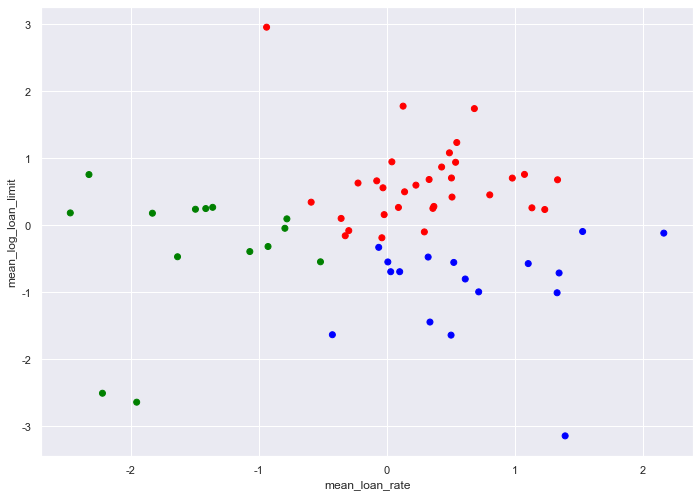

In [414]:
color={1:'red', 2:'blue', 3:'green'}
plt.scatter(bank_grp_loan["loan_rate"],bank_grp_loan["log_loan_limit"], c = [color[i] for i in bank_grp_loan["bank_label"]])

plt.xlabel("mean_loan_rate")
plt.ylabel("mean_log_loan_limit")

In [415]:
loan_result_model2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500253 entries, 13276 to 13489704
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   application_id         int64  
 1   loanapply_insert_time  object 
 2   bank_id                int64  
 3   product_id             int64  
 4   loan_limit             float64
 5   loan_rate              float64
 6   is_applied             float64
 7   log_loan_limit         float64
 8   is_applied_tot         float64
 9   user_id                int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 293.8+ MB


In [416]:
#bank_id cluster 변수 train 추가
loan_result_model2_train = pd.merge(loan_result_model2_train, bank_grp_loan[['bank_id','bank_label']],how='left',on='bank_id')
#bank_id cluster 변수 valid 추가
loan_result_model2_valid = pd.merge(loan_result_model2_valid, bank_grp_loan[['bank_id','bank_label']],how='left',on='bank_id')


#bank_id cluster 변수 test 추가
loan_result_model2_test = pd.merge(loan_result_model2_test, bank_grp_loan[['bank_id','bank_label']],how='left',on='bank_id')

In [417]:
print("train NA 개수 : ",loan_result_model2_train.isna().sum().sum())
print("valid NA 개수 : ",loan_result_model2_valid.isna().sum().sum())

train NA 개수 :  0
valid NA 개수 :  0


In [418]:
#train preprocess

In [419]:
#같은 application_id 내에서 loan_limit 과 loan_rate의 순위
loan_rate_rank = loan_result_model2_train.groupby("application_id").rank(ascending=True)["loan_rate"]
loan_limit_rank = loan_result_model2_train.groupby("application_id").rank(ascending=False)["loan_limit"]

In [420]:
loan_result_model2_train.drop(["is_applied_tot", "loanapply_insert_time"], axis = 1,inplace = True)

In [421]:
loan_result_model2_train["loan_rate_rank"] = loan_rate_rank
loan_result_model2_train["loan_limit_rank"] = loan_limit_rank

In [422]:
#loan_result_model2_train["bank_id"] = loan_result_model2_train["bank_id"].astype(object)
#loan_result_model2_train["product_id"] = loan_result_model2_train["product_id"].astype(object)

In [423]:
loan_result_model2_train_2 = pd.merge(loan_result_model2_train, user_spec6[["application_id","log_desired_amount","credit_score_last","time_rank"]],how='left',on='application_id')

In [424]:
#valid preprocess

In [425]:
#같은 application_id 내에서 loan_limit 과 loan_rate의 순위
loan_rate_rank = loan_result_model2_valid.groupby("application_id").rank(ascending=True)["loan_rate"]
loan_limit_rank = loan_result_model2_valid.groupby("application_id").rank(ascending=False)["loan_limit"]

In [426]:
loan_result_model2_valid.drop(["is_applied_tot", "loanapply_insert_time"], axis = 1,inplace = True)

In [427]:
loan_result_model2_valid["loan_rate_rank"] = loan_rate_rank
loan_result_model2_valid["loan_limit_rank"] = loan_limit_rank

In [428]:
loan_result_model2_valid_2 = pd.merge(loan_result_model2_valid, user_spec6[["application_id","log_desired_amount","credit_score_last","time_rank"]],how='left',on='application_id')

In [429]:
#test preprocess

In [430]:
#같은 application_id 내에서 loan_limit 과 loan_rate의 순위
loan_rate_rank = loan_result_model2_test.groupby("application_id").rank(ascending=True)["loan_rate"]
loan_limit_rank = loan_result_model2_test.groupby("application_id").rank(ascending=False)["loan_limit"]

In [431]:
loan_result_model2_test.drop(["is_applied_tot", "loanapply_insert_time"], axis = 1,inplace = True)

In [432]:
loan_result_model2_test["loan_rate_rank"] = loan_rate_rank
loan_result_model2_test["loan_limit_rank"] = loan_limit_rank

In [433]:
loan_result_model2_test = pd.merge(loan_result_model2_test, user_spec6[["application_id","log_desired_amount","credit_score_last","time_rank"]],how='left',on='application_id')

In [434]:
#마지막 test 데이터에 붙일거임
last_product_id = loan_result_model2_test["product_id"]

In [435]:
loan_result_model2_train_2.drop(["bank_id","product_id"],axis=1,inplace = True)
loan_result_model2_valid_2.drop(["bank_id","product_id"],axis=1,inplace = True)
loan_result_model2_test.drop(["bank_id","product_id"],axis=1,inplace = True)

In [436]:
#rank 2개의 제곱합루트
loan_result_model2_train_2["loan_rank_ed"] = np.sqrt(loan_result_model2_train_2["loan_rate_rank"]**2 + loan_result_model2_train_2["loan_limit_rank"]**2)
loan_result_model2_valid_2["loan_rank_ed"] = np.sqrt(loan_result_model2_valid_2["loan_rate_rank"]**2 + loan_result_model2_valid_2["loan_limit_rank"]**2)
loan_result_model2_test["loan_rank_ed"] = np.sqrt(loan_result_model2_test["loan_rate_rank"]**2 + loan_result_model2_test["loan_limit_rank"]**2)

In [437]:
#필요 금액과 대출 한도 간의 거리 / 금리
train_rate = (np.exp(loan_result_model2_train_2["log_desired_amount"]) - loan_result_model2_train_2["loan_limit"])/loan_result_model2_train_2["loan_rate"]
valid_rate = (np.exp(loan_result_model2_valid_2["log_desired_amount"]) - loan_result_model2_valid_2["loan_limit"])/loan_result_model2_valid_2["loan_rate"]
test_rate = (np.exp(loan_result_model2_test["log_desired_amount"]) - loan_result_model2_test["loan_limit"])/loan_result_model2_test["loan_rate"]
loan_result_model2_train_2['log_money_distance_rate'] = np.log(train_rate - train_rate.min() + 1)
loan_result_model2_valid_2['log_money_distance_rate'] = np.log(valid_rate - valid_rate.min() + 1)
loan_result_model2_test['log_money_distance_rate'] = np.log(test_rate - test_rate.min() + 1)

In [438]:
loan_result_model2_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500253 entries, 0 to 3500252
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   application_id           int64  
 1   loan_limit               float64
 2   loan_rate                float64
 3   is_applied               float64
 4   log_loan_limit           float64
 5   user_id                  int64  
 6   bank_label               object 
 7   loan_rate_rank           float64
 8   loan_limit_rank          float64
 9   log_desired_amount       float64
 10  credit_score_last        float64
 11  time_rank                float64
 12  loan_rank_ed             float64
 13  log_money_distance_rate  float64
dtypes: float64(11), int64(2), object(1)
memory usage: 400.6+ MB


In [439]:
loan_result_model2_train_2_dummy = pd.get_dummies(loan_result_model2_train_2)
loan_result_model2_train_2_dummy.columns

Index(['application_id', 'loan_limit', 'loan_rate', 'is_applied',
       'log_loan_limit', 'user_id', 'loan_rate_rank', 'loan_limit_rank',
       'log_desired_amount', 'credit_score_last', 'time_rank', 'loan_rank_ed',
       'log_money_distance_rate', 'bank_label_1', 'bank_label_2',
       'bank_label_3'],
      dtype='object')

In [440]:
loan_result_model2_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2358173 entries, 0 to 2358172
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   application_id           int64  
 1   loan_limit               float64
 2   loan_rate                float64
 3   is_applied               float64
 4   log_loan_limit           float64
 5   user_id                  int64  
 6   bank_label               object 
 7   loan_rate_rank           float64
 8   loan_limit_rank          float64
 9   log_desired_amount       float64
 10  credit_score_last        float64
 11  time_rank                float64
 12  loan_rank_ed             float64
 13  log_money_distance_rate  float64
dtypes: float64(11), int64(2), object(1)
memory usage: 269.9+ MB


In [441]:
loan_result_model2_valid_2_dummy = pd.get_dummies(loan_result_model2_valid_2)
loan_result_model2_valid_2_dummy.columns

Index(['application_id', 'loan_limit', 'loan_rate', 'is_applied',
       'log_loan_limit', 'user_id', 'loan_rate_rank', 'loan_limit_rank',
       'log_desired_amount', 'credit_score_last', 'time_rank', 'loan_rank_ed',
       'log_money_distance_rate', 'bank_label_1', 'bank_label_2',
       'bank_label_3'],
      dtype='object')

In [442]:
loan_result_model2_test.isna().sum()

application_id                   0
loan_limit                       0
loan_rate                        0
is_applied                 2876513
log_loan_limit                   0
user_id                          0
bank_label                       0
loan_rate_rank                   0
loan_limit_rank                  0
log_desired_amount               0
credit_score_last                0
time_rank                        0
loan_rank_ed                     0
log_money_distance_rate          0
dtype: int64

In [443]:
loan_result_model2_test_dummy = pd.get_dummies(loan_result_model2_test)
loan_result_model2_test_dummy.columns

Index(['application_id', 'loan_limit', 'loan_rate', 'is_applied',
       'log_loan_limit', 'user_id', 'loan_rate_rank', 'loan_limit_rank',
       'log_desired_amount', 'credit_score_last', 'time_rank', 'loan_rank_ed',
       'log_money_distance_rate', 'bank_label_1', 'bank_label_2',
       'bank_label_3'],
      dtype='object')

In [444]:
x_train_model2_dummy = loan_result_model2_train_2_dummy.drop(["application_id","user_id","is_applied","loan_limit"],axis=1)
x_valid_model2_dummy = loan_result_model2_valid_2_dummy.drop(["application_id","user_id","is_applied","loan_limit"],axis=1)

x_train_model2 = loan_result_model2_train_2.drop(["application_id","user_id","is_applied","loan_limit"],axis=1)
x_valid_model2 = loan_result_model2_valid_2.drop(["application_id","user_id","is_applied","loan_limit"],axis=1)

y_train_model2 = loan_result_model2_train_2["is_applied"]
y_valid_model2 = loan_result_model2_valid_2["is_applied"]

x_model2_total_dummy = pd.concat([x_train_model2_dummy,x_valid_model2_dummy])
x_model2_total = pd.concat([x_train_model2, x_valid_model2])
y_model2_total = pd.concat([y_train_model2, y_valid_model2])

In [445]:
weight_m2 = compute_class_weight(class_weight = "balanced" , 
                     classes=[0,1], 
                     y = y_train_model2)
weight_m2

array([0.56552983, 4.31505649])

### 모델 2_1 Xgboost

기본

In [446]:
evals = [(x_train_model2_dummy, y_train_model2),(x_valid_model2_dummy, y_valid_model2)]

In [447]:
xgb_02_BO_tuend = XGBClassifier(n_estimators = 500, max_depth = 14, learning_rate = 0.03, n_jobs=-1,scale_pos_weight = weight_m2[1]/weight_m2[0],
                          objective='binary:logistic')

xgb_02_BO_tuend.fit(x_train_model2_dummy, y_train_model2, eval_set = evals, eval_metric = "logloss",early_stopping_rounds = 200, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=14, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.630112972341255,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

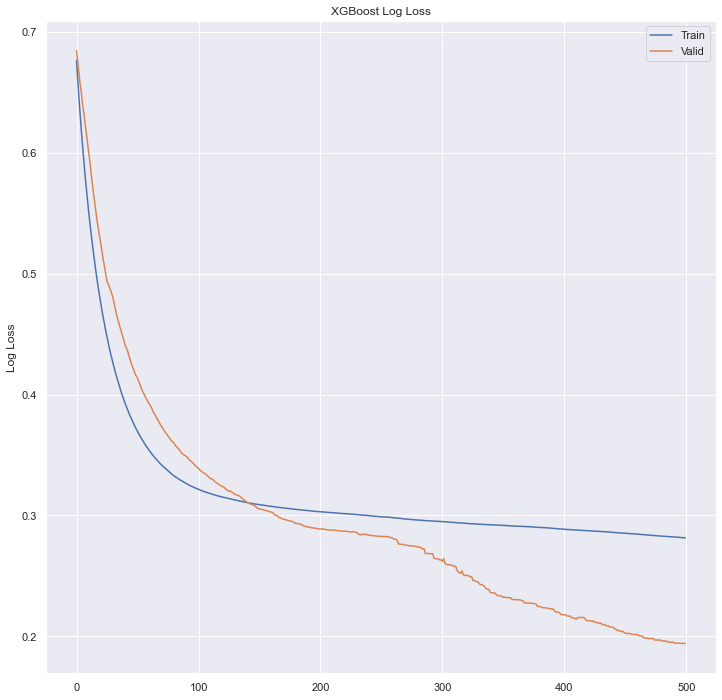

In [448]:
#retrieve performance metrics
results = xgb_02_BO_tuend.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Valid')
ax.legend()

plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

Text(0.5, 0, 'Xgboost Feature Importance')

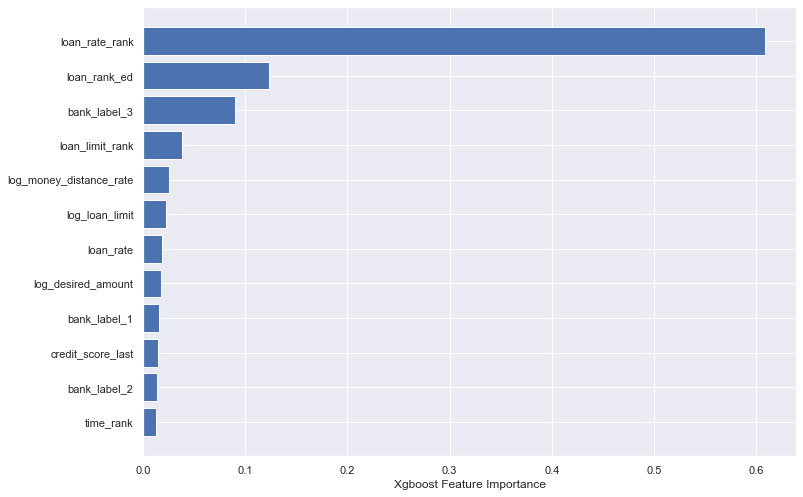

In [449]:
sorted_idx = xgb_02_BO_tuend.feature_importances_.argsort()
plt.barh(x_train_model2_dummy.columns[sorted_idx], xgb_02_BO_tuend.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [450]:
pred_xgb_02_BO_train = xgb_02_BO_tuend.predict(x_train_model2_dummy)
pred_xgb_02_BO_valid = xgb_02_BO_tuend.predict(x_valid_model2_dummy)
proba_xgb_02_BO_valid = xgb_02_BO_tuend.predict_proba(x_valid_model2_dummy)
#y_train_model2, y_valid_model2

In [451]:
print("Train Set 결과")
print("accuracy_score : ",accuracy_score(y_train_model2, pred_xgb_02_BO_train))
print("recall_score : ",recall_score(y_train_model2, pred_xgb_02_BO_train))
print("precision_score : ",precision_score(y_train_model2, pred_xgb_02_BO_train))
print("f1_score : ",f1_score(y_train_model2, pred_xgb_02_BO_train))

Train Set 결과
accuracy_score :  0.8673804436422167
recall_score :  0.9212472817109072
precision_score :  0.4636334758644308
f1_score :  0.6168344487623525


In [452]:
print("Valid Set 결과")
print("accuracy_score : ",accuracy_score(y_valid_model2, pred_xgb_02_BO_valid))
print("recall_score : ",recall_score(y_valid_model2, pred_xgb_02_BO_valid))
print("precision_score : ",precision_score(y_valid_model2, pred_xgb_02_BO_valid))
print("f1_score : ",f1_score(y_valid_model2, pred_xgb_02_BO_valid))

Valid Set 결과
accuracy_score :  0.9275731678719076
recall_score :  0.3499065166400381
precision_score :  0.4063896653558851
f1_score :  0.37603890007196955


In [459]:
#전체 데이터에 대한 학습
xgb_02_BO_last = XGBClassifier(n_estimators = 500, max_depth = 14, learning_rate = 0.03, n_jobs=-1, scale_pos_weight = weight_m2[1]/weight_m2[0],
                          objective='binary:logistic')

xgb_02_BO_last.fit(x_model2_total_dummy, y_model2_total)

[13:06:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=14, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.630112972341255,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=None)

In [460]:
pred_xgb_02_BO_test = xgb_02_BO_last.predict(loan_result_model2_test_dummy.drop(["application_id","user_id","is_applied","loan_limit"],axis=1))
proba_xgb_02_BO_test = xgb_02_BO_last.predict_proba(loan_result_model2_test_dummy.drop(["application_id","user_id","is_applied","loan_limit"],axis=1))

### 모델 2_2 LGBM

In [239]:
evals = [(x_train_model2_dummy, y_train_model2),(x_valid_model2_dummy, y_valid_model2)]

In [240]:
lgb_02_BO_tuend = LGBMClassifier(max_depth=8, learning_rate = 0.1 , num_leaves = 200,n_estimators = 1000, n_jobs=-1, boost_from_average=False,
                        class_weight={0:weight_m2[0],1:weight_m2[1]})

lgb_02_BO_tuend.fit(x_train_model2_dummy, y_train_model2, eval_set = evals, eval_metric = "logloss",early_stopping_rounds = 200, verbose=False)

LGBMClassifier(boost_from_average=False,
               class_weight={0: 0.565529829219105, 1: 4.3150564861706275},
               max_depth=8, n_estimators=1000, num_leaves=200)

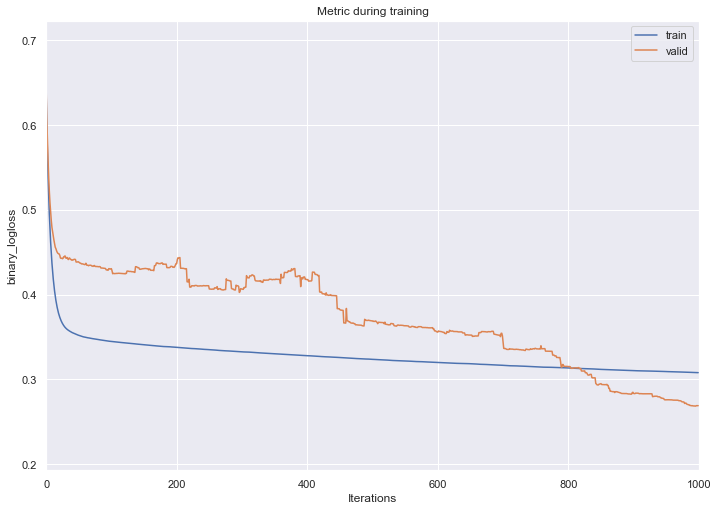

In [248]:
plot_metric(lgb_02_BO_tuend)
plt.legend(["train", "valid"])

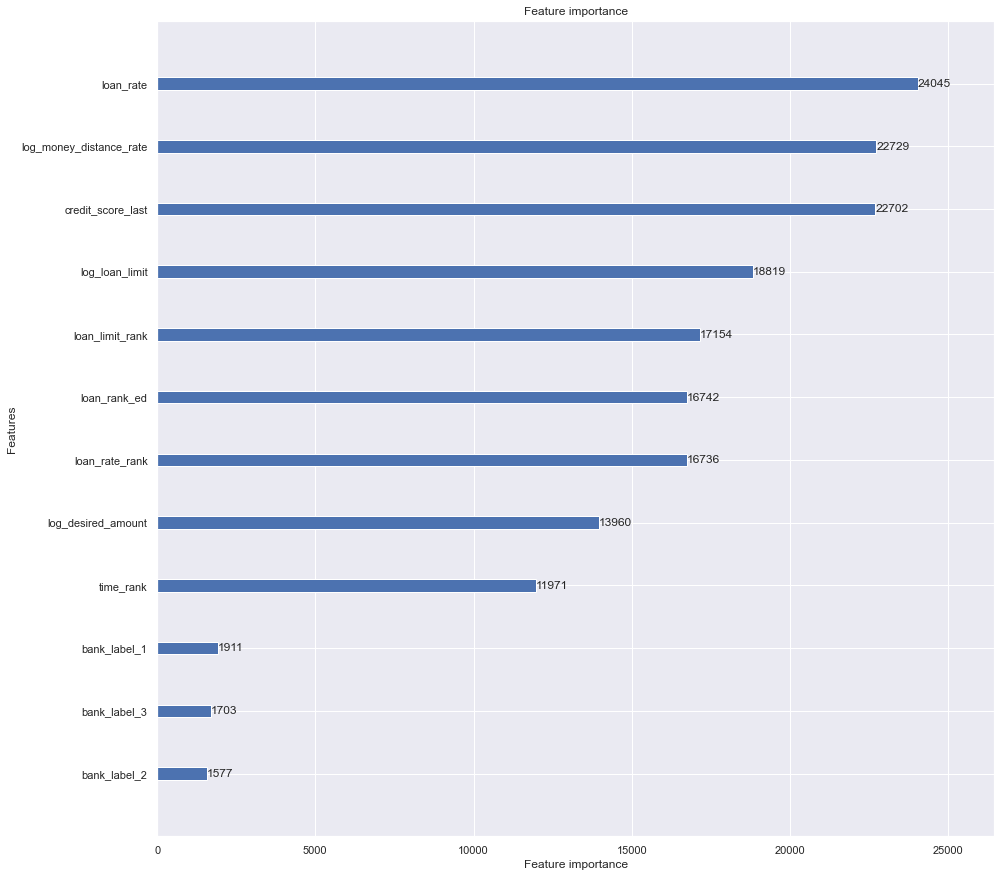

In [251]:
ax = lightgbm.plot_importance(lgb_02_BO_tuend, max_num_features=40, figsize=(15,15)) 
plt.show()

In [252]:
pred_lgb_02_BO_train = lgb_02_BO_tuend.predict(x_train_model2_dummy)
pred_lgb_02_BO_valid = lgb_02_BO_tuend.predict(x_valid_model2_dummy)
proba_lgb_02_BO_valid = lgb_02_BO_tuend.predict_proba(x_valid_model2_dummy)

In [253]:
print("Train Set 결과")
print("accuracy_score : ",accuracy_score(y_train_model2, pred_lgb_02_BO_train))
print("recall_score : ",recall_score(y_train_model2, pred_lgb_02_BO_train))
print("precision_score : ",precision_score(y_train_model2, pred_lgb_02_BO_train))
print("f1_score : ",f1_score(y_train_model2, pred_lgb_02_BO_train))

Train Set 결과
accuracy_score :  0.8429107838776225
recall_score :  0.886238676877407
precision_score :  0.4164312906791109
f1_score :  0.5666170638048338


In [254]:
print("Valid Set 결과")
print("accuracy_score : ",accuracy_score(y_valid_model2, pred_lgb_02_BO_valid))
print("recall_score : ",recall_score(y_valid_model2, pred_lgb_02_BO_valid))
print("precision_score : ",precision_score(y_valid_model2, pred_lgb_02_BO_valid))
print("f1_score : ",f1_score(y_valid_model2, pred_lgb_02_BO_valid))

Valid Set 결과
accuracy_score :  0.8848307566917271
recall_score :  0.6107080939592753
precision_score :  0.295328712897329
f1_score :  0.3981287161405989


In [455]:
#전체 데이터에 대한 학습
lgb_02_BO_last = LGBMClassifier(max_depth=8, learning_rate = 0.1 , num_leaves = 200, n_estimators = 500, n_jobs=-1, boost_from_average=False,
                        class_weight={0:weight_m2[0],1:weight_m2[1]})

lgb_02_BO_last.fit(x_model2_total_dummy, y_model2_total)

LGBMClassifier(boost_from_average=False,
               class_weight={0: 0.565529829219105, 1: 4.3150564861706275},
               max_depth=8, n_estimators=500, num_leaves=200)

In [456]:
pred_lgb_02_BO_test = lgb_02_BO_last.predict(loan_result_model2_test_dummy.drop(["application_id","user_id","is_applied","loan_limit"],axis=1))
proba_lgb_02_BO_test = lgb_02_BO_last.predict_proba(loan_result_model2_test_dummy.drop(["application_id","user_id","is_applied","loan_limit"],axis=1))

### 모델 2_3 Catboost

In [342]:
evals = [(x_train_model2, y_train_model2),(x_valid_model2, y_valid_model2)]

In [356]:
cat_02_BO_tuend = CatBoostClassifier(max_depth = 8,n_estimators = 2000, eval_metric = "Logloss",
                               cat_features=np.where(x_train_model2.dtypes != np.float)[0], class_weights={0:weight_m2[0],1:weight_m2[1]},
                        random_state=42,early_stopping_rounds = 300)

cat_02_BO_tuend.fit(x_train_model2, y_train_model2, eval_set = evals, verbose=False, plot=True
               )

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

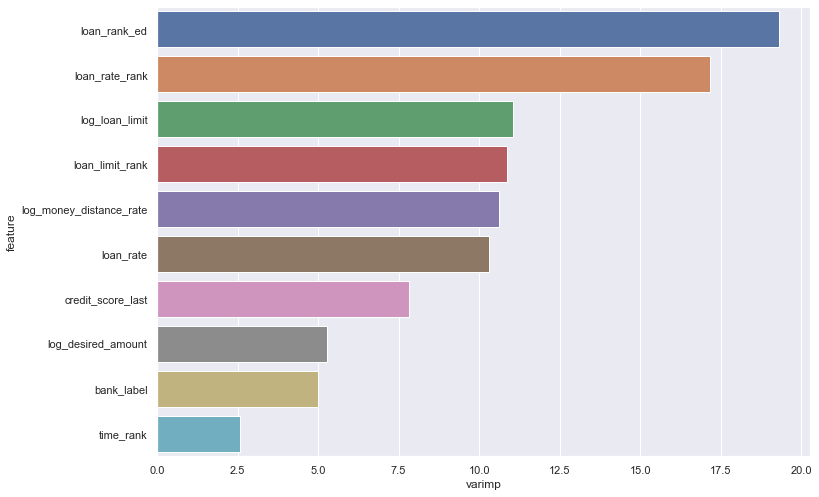

In [344]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
cat_feature_imp = pd.DataFrame([cat_02_BO_tuend.feature_names_ , cat_02_BO_tuend.feature_importances_]).T
cat_feature_imp.columns = ["feature","varimp"]
cat_feature_imp = cat_feature_imp.sort_values(by="varimp", ascending = False)
sns.barplot(y="feature", x="varimp",data = cat_feature_imp,)
plt.show()

In [345]:
pred_cat_02_BO_train = cat_02_BO_tuend.predict(x_train_model2)
pred_cat_02_BO_valid = cat_02_BO_tuend.predict(x_valid_model2)
proba_cat_02_BO_valid = cat_02_BO_tuend.predict_proba(x_valid_model2)
#y_train_model2, y_valid_model2

In [346]:
print("Train Set 결과")
print("accuracy_score : ",accuracy_score(y_train_model2, pred_cat_02_BO_train))
print("recall_score : ",recall_score(y_train_model2, pred_cat_02_BO_train))
print("precision_score : ",precision_score(y_train_model2, pred_cat_02_BO_train))
print("f1_score : ",f1_score(y_train_model2, pred_cat_02_BO_train))

Train Set 결과
accuracy_score :  0.830698523792423
recall_score :  0.864778370062083
precision_score :  0.39475923358124293
f1_score :  0.5420707497670164


In [347]:
print("Valid Set 결과")
print("accuracy_score : ",accuracy_score(y_valid_model2, pred_cat_02_BO_valid))
print("recall_score : ",recall_score(y_valid_model2, pred_cat_02_BO_valid))
print("precision_score : ",precision_score(y_valid_model2, pred_cat_02_BO_valid))
print("f1_score : ",f1_score(y_valid_model2, pred_cat_02_BO_valid))

Valid Set 결과
accuracy_score :  0.8547655324694159
recall_score :  0.7473229765101812
precision_score :  0.26471246956601313
f1_score :  0.3909462093297862


In [360]:
lea = cat_02_BO_tuend.get_all_params()["learning_rate"]
lea

In [457]:
#전체 데이터에 대한 학습
cat_02_BO_last = CatBoostClassifier(max_depth = 8,n_estimators = 400, learning_rate = lea,
                               cat_features=np.where(x_train_model2.dtypes != np.float)[0], class_weights={0:weight_m2[0],1:weight_m2[1]},
                        random_state=42,early_stopping_rounds = 300)

cat_02_BO_last.fit(x_model2_total, y_model2_total)

0:	learn: 0.5739579	total: 3.94s	remaining: 26m 10s
1:	learn: 0.5029368	total: 8.3s	remaining: 27m 31s
2:	learn: 0.4597792	total: 12.6s	remaining: 27m 52s
3:	learn: 0.4297064	total: 17.2s	remaining: 28m 27s
4:	learn: 0.4123537	total: 21.3s	remaining: 27m 58s
5:	learn: 0.3978995	total: 25.3s	remaining: 27m 38s
6:	learn: 0.3901242	total: 27.4s	remaining: 25m 39s
7:	learn: 0.3838148	total: 29.1s	remaining: 23m 45s
8:	learn: 0.3786550	total: 31.1s	remaining: 22m 31s
9:	learn: 0.3750654	total: 32.8s	remaining: 21m 20s
10:	learn: 0.3724543	total: 34.6s	remaining: 20m 22s
11:	learn: 0.3704178	total: 36.3s	remaining: 19m 33s
12:	learn: 0.3686761	total: 38.1s	remaining: 18m 53s
13:	learn: 0.3673203	total: 39.9s	remaining: 18m 19s
14:	learn: 0.3662074	total: 41.8s	remaining: 17m 53s
15:	learn: 0.3653416	total: 43.8s	remaining: 17m 30s
16:	learn: 0.3643832	total: 45.6s	remaining: 17m 8s
17:	learn: 0.3636305	total: 47.4s	remaining: 16m 46s
18:	learn: 0.3627901	total: 49.3s	remaining: 16m 28s
19:	l

154:	learn: 0.3499575	total: 5m 3s	remaining: 8m
155:	learn: 0.3499265	total: 5m 5s	remaining: 7m 57s
156:	learn: 0.3498760	total: 5m 7s	remaining: 7m 55s
157:	learn: 0.3498468	total: 5m 9s	remaining: 7m 53s
158:	learn: 0.3498167	total: 5m 10s	remaining: 7m 51s
159:	learn: 0.3497773	total: 5m 12s	remaining: 7m 48s
160:	learn: 0.3497445	total: 5m 14s	remaining: 7m 46s
161:	learn: 0.3497139	total: 5m 15s	remaining: 7m 43s
162:	learn: 0.3496866	total: 5m 17s	remaining: 7m 41s
163:	learn: 0.3496483	total: 5m 19s	remaining: 7m 39s
164:	learn: 0.3496100	total: 5m 20s	remaining: 7m 37s
165:	learn: 0.3495620	total: 5m 22s	remaining: 7m 34s
166:	learn: 0.3495248	total: 5m 24s	remaining: 7m 32s
167:	learn: 0.3494907	total: 5m 26s	remaining: 7m 30s
168:	learn: 0.3494559	total: 5m 28s	remaining: 7m 28s
169:	learn: 0.3494267	total: 5m 29s	remaining: 7m 26s
170:	learn: 0.3493925	total: 5m 31s	remaining: 7m 24s
171:	learn: 0.3493583	total: 5m 33s	remaining: 7m 21s
172:	learn: 0.3493119	total: 5m 35s	

307:	learn: 0.3460387	total: 9m 45s	remaining: 2m 54s
308:	learn: 0.3460251	total: 9m 47s	remaining: 2m 53s
309:	learn: 0.3460007	total: 9m 49s	remaining: 2m 51s
310:	learn: 0.3459842	total: 9m 51s	remaining: 2m 49s
311:	learn: 0.3459636	total: 9m 53s	remaining: 2m 47s
312:	learn: 0.3459488	total: 9m 55s	remaining: 2m 45s
313:	learn: 0.3459341	total: 9m 57s	remaining: 2m 43s
314:	learn: 0.3459145	total: 9m 59s	remaining: 2m 41s
315:	learn: 0.3458874	total: 10m 1s	remaining: 2m 39s
316:	learn: 0.3458769	total: 10m 3s	remaining: 2m 37s
317:	learn: 0.3458550	total: 10m 5s	remaining: 2m 36s
318:	learn: 0.3458398	total: 10m 6s	remaining: 2m 34s
319:	learn: 0.3458176	total: 10m 8s	remaining: 2m 32s
320:	learn: 0.3457932	total: 10m 10s	remaining: 2m 30s
321:	learn: 0.3457728	total: 10m 12s	remaining: 2m 28s
322:	learn: 0.3457501	total: 10m 14s	remaining: 2m 26s
323:	learn: 0.3457300	total: 10m 16s	remaining: 2m 24s
324:	learn: 0.3457046	total: 10m 18s	remaining: 2m 22s
325:	learn: 0.3456793	t

In [458]:
pred_cat_02_BO_test = cat_02_BO_last.predict(loan_result_model2_test.drop(["application_id","user_id","is_applied","loan_limit"],axis=1))
proba_cat_02_BO_test = cat_02_BO_last.predict_proba(loan_result_model2_test.drop(["application_id","user_id","is_applied","loan_limit"],axis=1))

## 앙상블

In [280]:
def my_fbeta_score(precision, recall, beta=1.5):
    return (1.0 + (beta ** 2)) * (precision * recall) / (((beta ** 2) * precision) + recall )


def best_standard(prob):
    
    mypredictions_model2 = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


    for i in tqdm_notebook(prob):
        for j in range(0,17):
            std_prob = (j+2)* 0.05
            if i[1] >= std_prob:
                mypredictions_model2[j].append(1)
            else:
                mypredictions_model2[j].append(0)
            
    std_p = []
    accuracy = []
    recall = []
    precision = []
    f1_s = []
    f1_5_s = []
    f0_66_s = []

    for i in tqdm_notebook(range(0,17)):
        std_p.append((i+2) * 0.5)
        accuracy.append(accuracy_score(y_valid_model2, mypredictions_model2[i]))
        recall.append(recall_score(y_valid_model2, mypredictions_model2[i]))
        precision.append(precision_score(y_valid_model2, mypredictions_model2[i]))
        f1_s.append(f1_score(y_valid_model2, mypredictions_model2[i]))
        f1_5_s.append(my_fbeta_score(precision_score(y_valid_model2, mypredictions_model2[i]), recall_score(y_valid_model2, mypredictions_model2[i])))
        f0_66_s.append(my_fbeta_score(precision_score(y_valid_model2, mypredictions_model2[i]), recall_score(y_valid_model2, mypredictions_model2[i]),2/3))

    result_model2 = pd.DataFrame()
    result_model2["std_p"] = std_p
    result_model2["accuracy"] = accuracy
    result_model2["recall"] = recall
    result_model2["precision"] = precision
    result_model2["f1_s"] = f1_s
    result_model2["f1_5_s"] = f1_5_s
    result_model2["f0_66_s"] = f0_66_s
    return result_model2

### 1번. 확률 평균으로 기준값 바꿔가기

In [269]:
model2_prob_valid = (proba_xgb_02_BO_valid + proba_cat_02_BO_valid + proba_lgb_02_BO_valid)/3

In [270]:
result_model2_prob_valid_method1 = best_standard(model2_prob_valid)
result_model2_prob_valid_method1

  0%|          | 0/2358173 [00:00<?, ?it/s]

,std_p,accuracy,recall,precision,f1_s,f1_5_s,f0_66_s
0,1.0,0.674977,0.931455,0.153353,0.263349,0.363678,0.206407
1,1.5,0.738110,0.894850,0.179382,0.298856,0.401777,0.237912
2,2.0,0.781356,0.857368,0.203159,0.328481,0.430659,0.265491
3,2.5,0.815256,0.815896,0.227032,0.355220,0.453760,0.291843
4,3.0,0.843041,0.764510,0.251029,0.377956,0.469201,0.316421
5,3.5,0.865615,0.708454,0.275506,0.396730,0.477547,0.339308
6,4.0,0.882979,0.653914,0.299413,0.410752,0.479302,0.359356
7,4.5,0.897067,0.602074,0.324665,0.421850,0.476737,0.378297
8,5.0,0.908489,0.549920,0.350935,0.428451,0.468230,0.394902
9,5.5,0.917301,0.497413,0.376625,0.428673,0.452737,0.407038


In [464]:
max_i = result_model2_prob_valid_method1.loc[result_model2_prob_valid_method1["f1_s"] == result_model2_prob_valid_method1["f1_s"].max(),"std_p"]
max_i

9    5.5
Name: std_p, dtype: float64

In [465]:
prediction_method1 = []
for i in tqdm_notebook(model2_prob_valid):
    if i[1] >= max_i.values*0.1:
        prediction_method1.append(1)
    else:
        prediction_method1.append(0)

  0%|          | 0/2358173 [00:00<?, ?it/s]

In [278]:
print("Valid Set 결과")
print("accuracy_score : ",accuracy_score(y_valid_model2, prediction_method1))
print("recall_score : ",recall_score(y_valid_model2, prediction_method1))
print("precision_score : ",precision_score(y_valid_model2, prediction_method1))
print("f1_score : ",f1_score(y_valid_model2, prediction_method1))

Valid Set 결과
accuracy_score :  0.9173012327763909
recall_score :  0.4974130604752354
precision_score :  0.3766247805741878
f1_score :  0.4286727094819858


### 2번. 모델 별 최적의 기준값으로 분류 후 하나라도 1이면 최종 1

In [281]:
result_model2_xgb = best_standard(proba_xgb_02_BO_valid)
result_model2_cat = best_standard(proba_cat_02_BO_valid)
result_model2_lgb = best_standard(proba_lgb_02_BO_valid)

  0%|          | 0/2358173 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2358173 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2358173 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [282]:
result_model2_xgb

,std_p,accuracy,recall,precision,f1_s,f1_5_s,f0_66_s
0,1.0,0.849774,0.670850,0.243925,0.357765,0.436032,0.303319
1,1.5,0.880074,0.586634,0.279881,0.378961,0.438692,0.333546
2,2.0,0.898496,0.520814,0.312049,0.390267,0.431906,0.355951
3,2.5,0.910695,0.466594,0.341831,0.394585,0.419485,0.372476
4,3.0,0.919088,0.419526,0.369207,0.392762,0.402641,0.383355
5,3.5,0.925011,0.375681,0.393942,0.384595,0.381117,0.388137
6,4.0,0.929083,0.333617,0.414828,0.369816,0.355001,0.385922
7,4.5,0.932012,0.293891,0.433588,0.350327,0.326232,0.378264
8,5.0,0.934168,0.254927,0.450944,0.325719,0.294288,0.364668
9,5.5,0.935709,0.217140,0.466930,0.296429,0.259924,0.344863


In [283]:
result_model2_cat

,std_p,accuracy,recall,precision,f1_s,f1_5_s,f0_66_s
0,1.0,0.564877,0.964306,0.121990,0.216581,0.308622,0.166828
1,1.5,0.635953,0.944753,0.140459,0.244559,0.342066,0.190310
2,2.0,0.685385,0.925349,0.156976,0.268418,0.369238,0.210847
3,2.5,0.723349,0.904912,0.172519,0.289790,0.392375,0.229729
4,3.0,0.753884,0.882456,0.187326,0.309047,0.412018,0.247254
5,3.5,0.779302,0.859993,0.201954,0.327095,0.429443,0.264142
6,4.0,0.801581,0.836142,0.216984,0.344554,0.445232,0.281010
7,4.5,0.821385,0.809437,0.232425,0.361149,0.458899,0.297729
8,5.0,0.839224,0.781167,0.248779,0.377375,0.471019,0.314791
9,5.5,0.855821,0.750539,0.266843,0.393709,0.481812,0.332845


In [284]:
result_model2_lgb

,std_p,accuracy,recall,precision,f1_s,f1_5_s,f0_66_s
0,1.0,0.709241,0.878893,0.162174,0.273822,0.372439,0.216496
1,1.5,0.755188,0.839963,0.182405,0.299723,0.398236,0.240283
2,2.0,0.787396,0.802964,0.200014,0.320254,0.416572,0.260112
3,2.5,0.811811,0.768297,0.216192,0.337433,0.430231,0.277564
4,3.0,0.831821,0.734745,0.232084,0.352746,0.440913,0.293963
5,3.5,0.848189,0.703627,0.247652,0.366359,0.449165,0.309331
6,4.0,0.862068,0.672557,0.263073,0.378209,0.454758,0.323718
7,4.5,0.874027,0.642085,0.278699,0.388687,0.458243,0.337464
8,5.0,0.884831,0.610708,0.295329,0.398129,0.459669,0.351121
9,5.5,0.894517,0.577442,0.312798,0.405784,0.458169,0.364149


In [285]:
std_xgb = result_model2_xgb.loc[result_model2_xgb["f1_s"] == result_model2_xgb["f1_s"].max(),"std_p"]
std_cat = result_model2_cat.loc[result_model2_cat["f1_s"] == result_model2_cat["f1_s"].max(),"std_p"]
std_lgb = result_model2_cat.loc[result_model2_cat["f1_s"] == result_model2_cat["f1_s"].max(),"std_p"]

In [294]:
prediction_xgb = []
for i in tqdm_notebook(proba_xgb_02_BO_valid):
    if i[1] >= std_xgb.values*0.1:
        prediction_xgb.append(1)
    else:
        prediction_xgb.append(0)
        
        
prediction_cat = []
for i in tqdm_notebook(proba_cat_02_BO_valid):
    if i[1] >= std_cat.values*0.1:
        prediction_cat.append(1)
    else:
        prediction_cat.append(0)
        
        
prediction_lgb = []
for i in tqdm_notebook(proba_lgb_02_BO_valid):
    if i[1] >= std_lgb.values*0.1:
        prediction_lgb.append(1)
    else:
        prediction_lgb.append(0)
        
prediction_method2 = np.max([prediction_xgb, prediction_cat, prediction_lgb],axis=0)

  0%|          | 0/2358173 [00:00<?, ?it/s]

  0%|          | 0/2358173 [00:00<?, ?it/s]

  0%|          | 0/2358173 [00:00<?, ?it/s]

In [295]:
print("Valid Set 결과")
print("accuracy_score : ",accuracy_score(y_valid_model2, prediction_method2))
print("recall_score : ",recall_score(y_valid_model2, prediction_method2))
print("precision_score : ",precision_score(y_valid_model2, prediction_method2))
print("f1_score : ",f1_score(y_valid_model2, prediction_method2))

Valid Set 결과
accuracy_score :  0.8944415867707756
recall_score :  0.6057653737634701
precision_score :  0.3181675344060449
f1_score :  0.41720534834228085


### 3번. 0.5 기준 하나라도 1이면 최종 1 

In [296]:
prediction_method3 = np.max([pred_xgb_02_BO_valid, pred_xgb_02_BO_valid, pred_xgb_02_BO_valid],axis=0)

In [297]:
print("Valid Set 결과")
print("accuracy_score : ",accuracy_score(y_valid_model2, prediction_method3))
print("recall_score : ",recall_score(y_valid_model2, prediction_method3))
print("precision_score : ",precision_score(y_valid_model2, prediction_method3))
print("f1_score : ",f1_score(y_valid_model2, prediction_method3))

Valid Set 결과
accuracy_score :  0.9341681038668495
recall_score :  0.25492742291872045
precision_score :  0.45094407696933253
f1_score :  0.3257193736834104


## test_set 에는 1번 앙상블 방법 적용

In [461]:
model2_prob_test = (proba_xgb_02_BO_test + proba_cat_02_BO_test + proba_lgb_02_BO_test)/3

In [466]:
prediction_test_model2 = []
for i in tqdm_notebook(model2_prob_test):
    if i[1] >= max_i.values*0.1:
        prediction_test_model2.append(1)
    else:
        prediction_test_model2.append(0)

  0%|          | 0/2876513 [00:00<?, ?it/s]

In [467]:
loan_result_model2_test["product_id"] = last_product_id
loan_result_model2_test["pred_model2"] = prediction_test_model2

In [471]:
tmp = loan_result_model2_test[["application_id","product_id","pred_model2"]]

tmp.isna().sum()

application_id    0
product_id        0
pred_model2       0
dtype: int64

In [475]:
tmp

,application_id,product_id,pred_model2
0,1748340,191,0
1,1748340,169,0
2,1748340,7,0
3,1748340,268,1
4,1748340,118,0
...,...,...,...
2876508,1428218,200,0
2876509,1428218,7,0
2876510,1428218,257,0
2876511,1428218,110,0


In [ ]:
# 제출 파일 생성

In [479]:
submission.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
3255189    False
3255190    False
3255191    False
3255192    False
3255193    False
Length: 3255194, dtype: bool

In [298]:
submission = pd.read_csv("데이터분석분야_퓨처스부문_평가데이터_팀명_개짖는소리.csv")

In [489]:
submission

,application_id,product_id,is_applied
0,4,220,NaN
1,4,191,NaN
2,8,29,NaN
3,8,159,NaN
4,8,85,NaN
...,...,...,...
3255189,2167778,258,NaN
3255190,2167791,29,NaN
3255191,2167822,149,NaN
3255192,2167822,157,NaN


In [490]:
tmp1 = pd.merge(submission,tmp,how='left',on=["application_id","product_id"])

In [498]:
tmp1.drop("is_applied",axis=1,inplace=True)

**1차 모델에서 0으로 예측된 application_id 들은 merge할 내용이 없기 때문에 .fillna(0) 적용**

In [500]:
submission_result = tmp1.fillna(0)

In [504]:
submission_result.rename(columns={"pred_model2":"is_applied"},inplace=True)

In [505]:
submission_result.to_csv("데이터분석분야_퓨처스부문_빅콘테스트팀_평가데이터.csv",index=False)